In [1]:
import os
import numpy as np
import pandas as pd
from Bio.PDB.Polypeptide import three_to_index
from Bio.PDB.Polypeptide import one_to_three

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
plt.rcParams['figure.figsize'] = np.array([10,6.180])    #golden ratio
plt.rcParams['figure.facecolor'] = 'w'

In [3]:
def get_filtered_B_inv_lambda_and_P(filtered_lamb, cutoff_mode, P, method='extend_all_after_first_noisy_mode'):
    if method == 'zero_all_after_first_noisy_mode':
        filtered_lamb_inv = 1 / filtered_lamb
        # for "zeroing unreliable eigenvalues"
        filtered_lamb_inv[cutoff_mode:] = 0.0
        filtered_B_inv = np.dot(
            P, np.dot(np.diag(filtered_lamb_inv), np.linalg.inv(P)))
        filtered_lamb = 1 / filtered_lamb_inv
    if method == 'extend_all_after_first_noisy_mode':
        # for "extending lowest reliable eigenvalue"
        filtered_lamb[cutoff_mode:] = filtered_lamb[cutoff_mode - 1]
        filtered_B_inv = np.dot(
            P, np.dot(np.diag(1 / filtered_lamb), np.linalg.inv(P)))

    return filtered_B_inv, filtered_lamb, P


def sort_eigenvalues_and_eigenvectors(eigenvalues, eigenvectors):
    idx = eigenvalues.argsort()[::-1]
    eigenvalues = eigenvalues[idx]
    eigenvectors = eigenvectors[:, idx]
    return eigenvalues, eigenvectors


def get_A_B(pre, n=201, first_half=False, second_half=False, all_ab=False):
    # pre = "/Users/weilu/Research/server/aug_2020/curated_single_chain_optimization/optimization_msa_mode_3/gamma_mode_3"
    A = np.load(f"{pre}/average_A.npy", allow_pickle=True)
    B = np.load(f"{pre}/average_B.npy", allow_pickle=True)
    A_prime = np.load(f"{pre}/average_A_prime.npy", allow_pickle=True)
    # half_B = np.load(f"{pre}/average_half_B.npy", allow_pickle=True)
    # other_half_B = np.load(f"{pre}/average_other_half_B.npy", allow_pickle=True)
    # std_half_B = np.load(f"{pre}/average_std_half_B.npy", allow_pickle=True)
#     A = A[:n]
#     B = B[:n,:n]
#     A_prime = A_prime[:n]
#     half_B = half_B[:n,:n]
#     other_half_B = other_half_B[:n, :n]
#     std_half_B = std_half_B[:n, :n]
    if second_half:
        half_n = int(n/2)
        A = A[half_n:]
        B = B[half_n:,half_n:]
        A_prime = A_prime[half_n:]
        # half_B = half_B[half_n:,half_n:]
        # other_half_B = other_half_B[half_n:, half_n:]
        # std_half_B = std_half_B[half_n:, half_n:]
    A_B_dic = {}
    A_B_dic["A"] = A
    A_B_dic["B"] = B
    # A_B_dic["half_B"] = half_B
    # A_B_dic["other_half_B"] = other_half_B
    # A_B_dic["std_half_B"] = std_half_B
    A_B_dic["A_prime"] = A_prime

    if all_ab:
        A_B_dic["a_all"] = np.load(f"{pre}/a_all.npy")
        A_B_dic["a_prime_all"] = np.load(f"{pre}/a_prime_all.npy")
        A_B_dic["b_all"] = np.load(f"{pre}/b_all.npy")
    return A_B_dic

def get_gamma(A, B, A_prime, c=-100, cutoff_range=range(100, 210, 10)):
    gamma_cutoff_dic = {}
    for cutoff in list(cutoff_range):
        # cutoff = 400
        lamb, P = np.linalg.eig(B)
        lamb, P = sort_eigenvalues_and_eigenvectors(lamb, P)
        filtered_lamb = np.copy(lamb)
        cutoff_mode = cutoff
        filtered_B_inv, filtered_lamb, P = get_filtered_B_inv_lambda_and_P(filtered_lamb,
                                                                           cutoff_mode, P)
        B_inv = filtered_B_inv
        lambda_2 = (A_prime.dot(B_inv).dot(A) - c) / (A_prime.dot(B_inv).dot(A_prime))
        gamma_new = B_inv.dot(A-A_prime*lambda_2)
        gamma_cutoff_dic[cutoff] = gamma_new
    return gamma_cutoff_dic

In [4]:
def compute_z(A_B, gamma, n=-1, start=0):
    if n == -1:
        n = A_B["A"].shape[0]
    # z score
    B = A_B["B"][start:start+n,start:start+n]
    A = A_B["A"][start:start+n]
    A_prime = A_B["A_prime"][start:start+n]
    x = gamma
    # x = gamma_mode15[520]
    e_std = (np.dot(x, B).dot(x))**0.5
    z = A.dot(x) / e_std
    print(z, e_std, A.dot(x), A_prime.dot(x))
    
def filter_B_matrix(B, cutoff):
    # cutoff = 520
    lamb, P = np.linalg.eig(B)
    lamb, P = sort_eigenvalues_and_eigenvectors(lamb, P)
    filtered_lamb = np.copy(lamb)
    cutoff_mode = cutoff
    filtered_B_inv, filtered_lamb, P = get_filtered_B_inv_lambda_and_P(filtered_lamb,
                                                                       cutoff_mode, P)
    B_new = np.linalg.inv(filtered_B_inv)
    return B_new

In [5]:
new_mode15_all_prime = np.loadtxt("/Users/weilu/Research/server/nov_2020/membrane_protein_structure_prediction/gamma_folder/new_mode15_all_prime.dat")

# Specific iterative optimization

In [58]:
pre = "/Users/weilu/Research/data/gamma_iter5_rescaled_by_zscore/"
iter5_rescaled = get_A_B(pre, n=690, all_ab=True)

In [59]:
A_B = iter5_rescaled
cutoff_range=list(range(200, 700, 20)) 
gamma_iter5_rescaled = get_gamma(A_B['A'], A_B['B'], A_B['A_prime'], c=-66, cutoff_range=cutoff_range)

In [60]:
x = gamma_iter5_rescaled[300]
A_B = iter5_rescaled
a_dot_x = A_B["a_all"].dot(x)
std_all = np.array([(np.dot(x, B).dot(x))**0.5 for B in A_B["b_all"]])
z = a_dot_x / std_all

In [62]:
x = gamma_iter5_rescaled[300]
A_B = iter5
a_dot_x = A_B["a_all"].dot(x)
std_all = np.array([(np.dot(x, B).dot(x))**0.5 for B in A_B["b_all"]])
z = a_dot_x / std_all

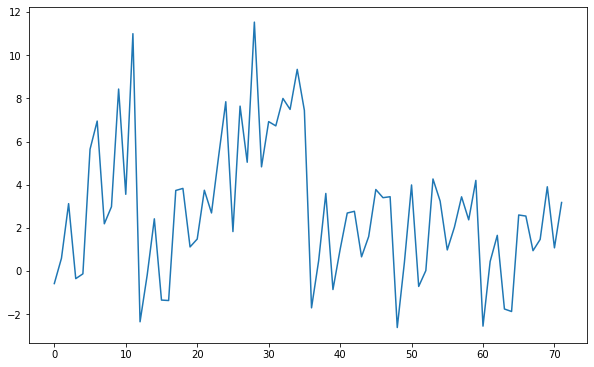

In [63]:
plt.plot(z)

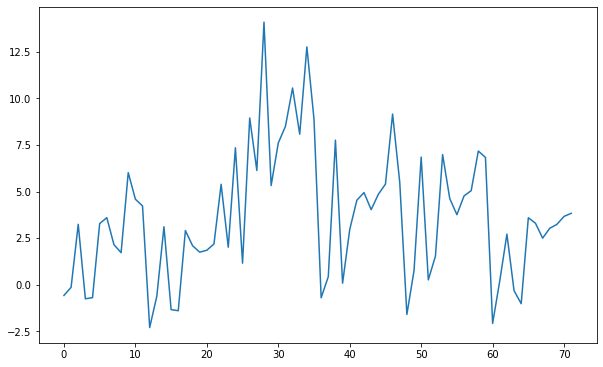

In [39]:
plt.plot(z)

In [64]:
from cvxopt import matrix, solvers
from cvxopt import matrix, solvers
B_new = filter_B_matrix(iter5_rescaled['B'], 300)
B = B_new
A_B = iter5_rescaled
A = A_B['A']
A_prime = A_B['A_prime']
a_all = A_B["a_all"]
n = len(A_prime)

Q = 2*matrix(B)
p = matrix(np.zeros(n))


# G = matrix(np.concatenate([-A.reshape(1,n), A_prime.reshape(1,n)]), (2,n))
# h = matrix([-100, -66], (2, 1), 'd')

# additional_constraint = np.diag([-1]*n)
additional_constraint = -a_all
n_additional_constraint = additional_constraint.shape[0]
G = matrix(np.concatenate([-A.reshape(1,n), A_prime.reshape(1,n), additional_constraint]), (2+n_additional_constraint,n))
h = matrix([-50, -66]+[-15]*n_additional_constraint, (2+n_additional_constraint, 1), 'd')

# additional_constraint = np.diag([-1]*n)
# additional_constraint2 = np.diag([1]*n)
# G = matrix(np.concatenate([-A.reshape(1,n), A_prime.reshape(1,n), 
#                            additional_constraint, additional_constraint2]), (2+n+n,n))
# h = matrix([-100, -66]+[2]*n+[2]*n, (2+n+n, 1), 'd')



sol=solvers.qp(Q, p, G=G, h=h)
x = np.array(sol['x']).flatten()
my_iter5_rescaled_gamma = x

     pcost       dcost       gap    pres   dres
 0:  1.1025e+02  1.4017e+03  6e+03  2e+00  9e+02
 1:  3.5676e+02 -7.4009e+02  2e+03  4e-01  2e+02
 2:  3.5563e+02  6.5725e+01  3e+02  6e-02  3e+01
 3:  3.1877e+02  2.0176e+02  1e+02  2e-02  9e+00
 4:  2.9348e+02  2.6215e+02  3e+01  4e-15  2e-13
 5:  2.8863e+02  2.8672e+02  2e+00  3e-15  3e-13
 6:  2.8822e+02  2.8812e+02  9e-02  3e-15  3e-12
 7:  2.8818e+02  2.8818e+02  4e-03  3e-15  2e-11
 8:  2.8818e+02  2.8818e+02  2e-04  3e-15  3e-10
Optimal solution found.


In [71]:
alpha = 0.9
mixed_x_iter5 = alpha * my_iter5_rescaled_gamma  + (1 - alpha) * new_mode15_all_prime
np.savetxt("/Users/weilu/Research/server/nov_2020//membrane_protein_structure_prediction/gamma_folder/mixed_iter5.dat", mixed_x_iter5)

In [69]:
compute_z(iter5, my_iter5_rescaled_gamma)

3.9476276840818234 19.21584236295249 75.85699128494353 -40.37163416420129


In [72]:
compute_z(iter5, mixed_x_iter5)

3.941974722789545 17.56138956203001 69.22655375058245 -42.911785666023796


In [65]:
x = my_iter5_rescaled_gamma
A_B = iter5
a_dot_x = A_B["a_all"].dot(x)
std_all = np.array([(np.dot(x, B).dot(x))**0.5 for B in A_B["b_all"]])
z = a_dot_x / std_all

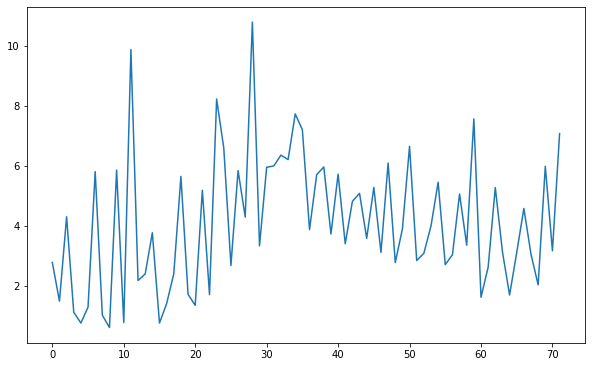

In [66]:
plt.plot(z)

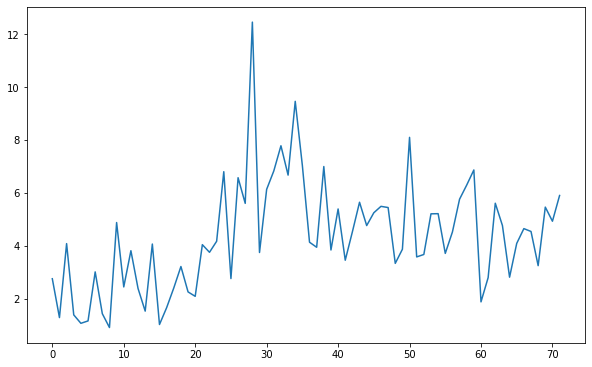

In [57]:
plt.plot(z)

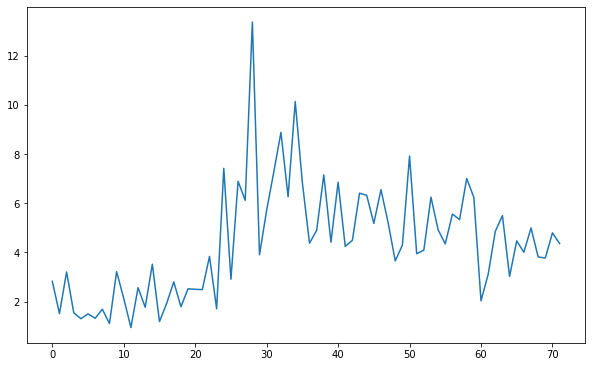

In [47]:
plt.plot(z)

In [6]:
pre = "/Users/weilu/Research/data/gamma_iter5/"
iter5 = get_A_B(pre, n=690, all_ab=True)

In [7]:
A_B = iter5
cutoff_range=list(range(200, 700, 20)) 
gamma_iter5 = get_gamma(A_B['A'], A_B['B'], A_B['A_prime'], c=-66, cutoff_range=cutoff_range)

In [8]:
x = gamma_iter5[300]
A_B = iter5
a_dot_x = A_B["a_all"].dot(x)
std_all = np.array([(np.dot(x, B).dot(x))**0.5 for B in A_B["b_all"]])
z = a_dot_x / std_all

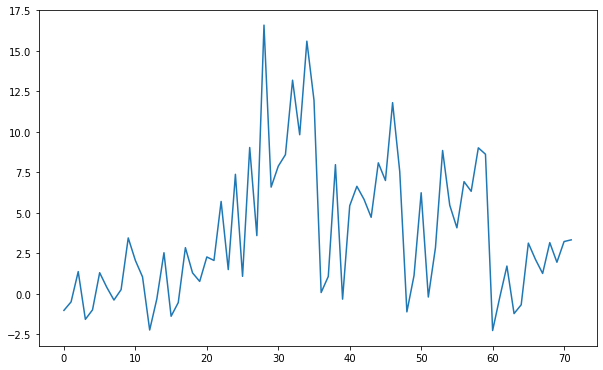

In [16]:
x = gamma_iter4[300]
A_B = iter5
a_dot_x = A_B["a_all"].dot(x)
std_all = np.array([(np.dot(x, B).dot(x))**0.5 for B in A_B["b_all"]])
z = a_dot_x / std_all
plt.plot(z)

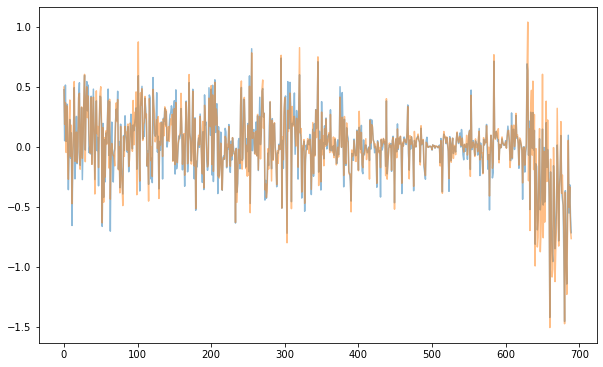

In [40]:
plt.plot(gamma_iter5[300], alpha=0.5)
plt.plot(gamma_iter5_rescaled[300], alpha=0.5)

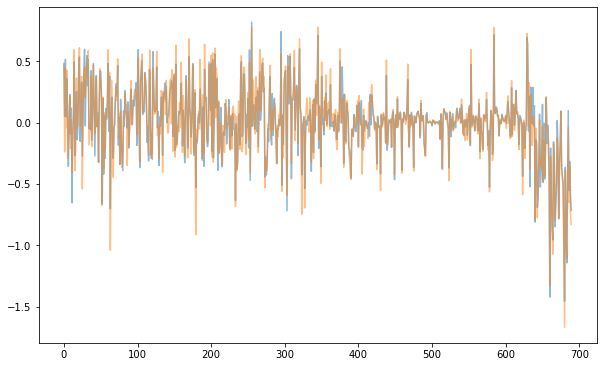

In [12]:
plt.plot(gamma_iter5[300], alpha=0.5)
plt.plot(gamma_iter4[300], alpha=0.5)

In [13]:
compute_z(iter5, gamma_iter5[300])

4.210362654716887 5.6735445137263945 23.88767994046749 -65.99999999999993


In [14]:
compute_z(iter5, gamma_iter4[300])

3.955464132262205 6.327146266807208 25.026800117932623 -70.5783318221217


In [45]:
from cvxopt import matrix, solvers
from cvxopt import matrix, solvers
B_new = filter_B_matrix(iter5['B'], 300)
B = B_new
A_B = iter5
A = A_B['A']
A_prime = A_B['A_prime']
a_all = A_B["a_all"]
n = len(A_prime)

Q = 2*matrix(B)
p = matrix(np.zeros(n))


# G = matrix(np.concatenate([-A.reshape(1,n), A_prime.reshape(1,n)]), (2,n))
# h = matrix([-100, -66], (2, 1), 'd')

# additional_constraint = np.diag([-1]*n)
additional_constraint = -a_all
n_additional_constraint = additional_constraint.shape[0]
G = matrix(np.concatenate([-A.reshape(1,n), A_prime.reshape(1,n), additional_constraint]), (2+n_additional_constraint,n))
h = matrix([-50, -66]+[-15]*n_additional_constraint, (2+n_additional_constraint, 1), 'd')

# additional_constraint = np.diag([-1]*n)
# additional_constraint2 = np.diag([1]*n)
# G = matrix(np.concatenate([-A.reshape(1,n), A_prime.reshape(1,n), 
#                            additional_constraint, additional_constraint2]), (2+n+n,n))
# h = matrix([-100, -66]+[2]*n+[2]*n, (2+n+n, 1), 'd')



sol=solvers.qp(Q, p, G=G, h=h)
x = np.array(sol['x']).flatten()
my_iter5_gamma = x

     pcost       dcost       gap    pres   dres
 0:  8.1383e+01  1.3157e+03  5e+03  2e+00  1e+03
 1:  3.2949e+02 -2.7307e+02  9e+02  3e-01  2e+02
 2:  2.5453e+02  3.0477e+01  2e+02  6e-02  4e+01
 3:  2.0522e+02  1.5913e+02  5e+01  4e-03  2e+00
 4:  1.9439e+02  1.8983e+02  5e+00  9e-05  6e-02
 5:  1.9326e+02  1.9288e+02  4e-01  5e-06  3e-03
 6:  1.9316e+02  1.9313e+02  2e-02  2e-07  1e-04
 7:  1.9315e+02  1.9315e+02  8e-04  3e-09  2e-06
 8:  1.9315e+02  1.9315e+02  1e-05  3e-11  2e-08
Optimal solution found.


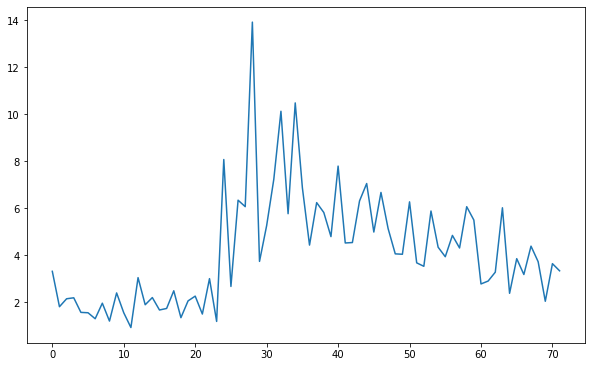

In [22]:
x = my_iter5_gamma
A_B = iter5
a_dot_x = A_B["a_all"].dot(x)
std_all = np.array([(np.dot(x, B).dot(x))**0.5 for B in A_B["b_all"]])
z = a_dot_x / std_all
plt.plot(z)

In [24]:
np.savetxt("/Users/weilu/Research/server/nov_2020/iterative_optimization/iteration1/gamma_iter5/init_z_score.txt", z)

In [26]:
z = np.loadtxt("/Users/weilu/Research/server/nov_2020/iterative_optimization/iteration1/gamma_iter5/init_z_score.txt")

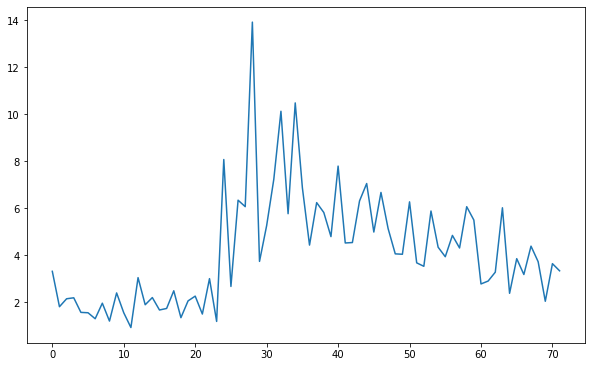

In [27]:
plt.plot(z)

array([1.03636256, 1.16847961, 1.13600466, 1.13212517, 1.19289531,
       1.19454528, 1.22145308, 1.15388504, 1.23227657, 1.11321583,
       1.19466311, 1.26329845, 1.05772287, 1.16032908, 1.13122841,
       1.18253219, 1.17587065, 1.10510014, 1.2166064 , 1.14448709,
       1.12558174, 1.20020969, 1.06120532, 1.23393986, 0.7635119 ,
       1.08896195, 0.84439538, 0.8588053 , 0.57686119, 1.00445896,
       0.90414627, 0.80077008, 0.68558887, 0.87517816, 0.67370203,
       0.81776764, 0.95615662, 0.84974134, 0.87240655, 0.93280385,
       0.77551045, 0.95021718, 0.94905444, 0.84596886, 0.80924117,
       0.92071372, 0.82764881, 0.91176513, 0.9815588 , 0.98272513,
       0.84804582, 1.00901118, 1.01997909, 0.86887167, 0.96218876,
       0.99010516, 0.92964349, 0.96438825, 0.8589207 , 0.89042809,
       1.07992938, 1.06957969, 1.03919949, 0.86140548, 1.11467248,
       0.99602761, 1.04698423, 0.95915269, 1.00544955, 1.14605241,
       1.01162517, 1.03466172])

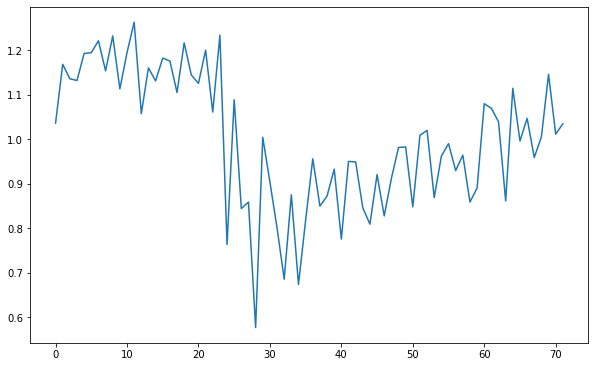

In [31]:
plt.plot(1/(10+z) * len(z) / np.sum(1/(10+z)) )

In [19]:
compute_z(iter5, my_iter5_gamma)

4.074643756826673 12.271011403047916 50.00000000337811 -66.00000003901717


In [20]:
compute_z(iter5, new_mode15_all_prime)

1.0781919580451818 8.859847145078165 9.55261594133284 -65.77314918242624


In [9]:
pre = "/Users/weilu/Research/data/gamma_iter4/"
iter4 = get_A_B(pre, n=690, all_ab=True)

In [10]:
A_B = iter4
cutoff_range=list(range(200, 700, 20)) 
gamma_iter4 = get_gamma(A_B['A'], A_B['B'], A_B['A_prime'], c=-66, cutoff_range=cutoff_range)

In [11]:
x = gamma_iter4[300]
A_B = iter4
a_dot_x = A_B["a_all"].dot(x)
std_all = np.array([(np.dot(x, B).dot(x))**0.5 for B in A_B["b_all"]])
z = a_dot_x / std_all

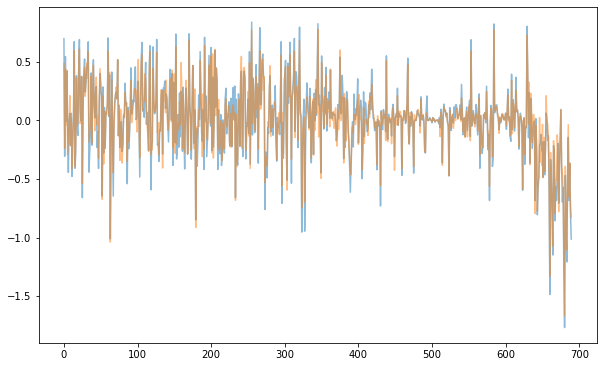

In [245]:
plt.plot(gamma_iter3[300], alpha=0.5)
plt.plot(gamma_iter4[300], alpha=0.5)

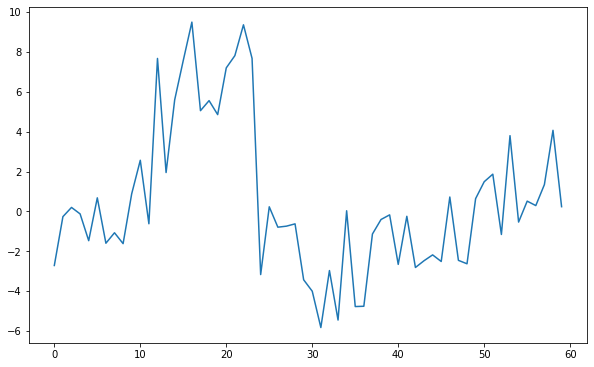

In [244]:
x = new_mode15_all_prime
A_B = iter4
a_dot_x = A_B["a_all"].dot(x)
std_all = np.array([(np.dot(x, B).dot(x))**0.5 for B in A_B["b_all"]])
z = a_dot_x / std_all
plt.plot(z)

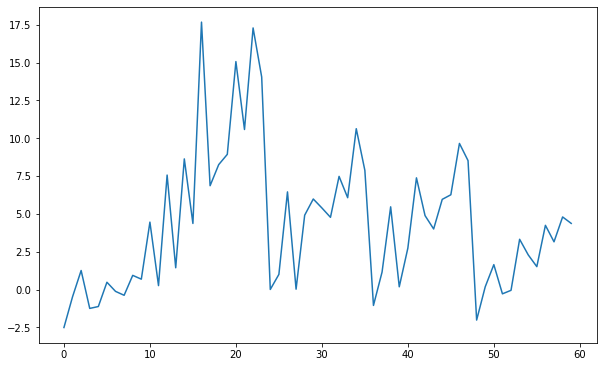

In [242]:
x = gamma_iter3[300]
A_B = iter4
a_dot_x = A_B["a_all"].dot(x)
std_all = np.array([(np.dot(x, B).dot(x))**0.5 for B in A_B["b_all"]])
z = a_dot_x / std_all
plt.plot(z)

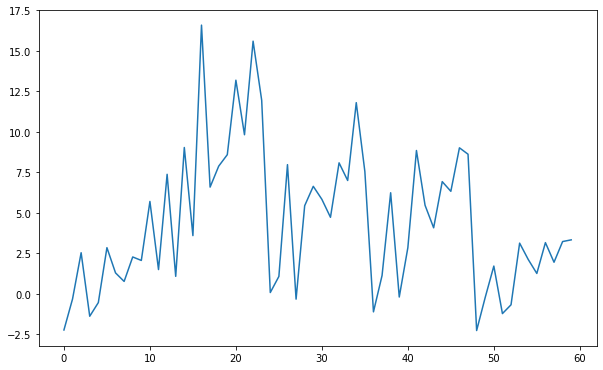

In [241]:
plt.plot(z)

In [267]:
from cvxopt import matrix, solvers
from cvxopt import matrix, solvers
B_new = filter_B_matrix(iter4['B'], 300)
B = B_new
A_B = iter4
A = A_B['A']
A_prime = A_B['A_prime']
a_all = A_B["a_all"]
n = len(A_prime)

Q = 2*matrix(B)
p = matrix(np.zeros(n))


# G = matrix(np.concatenate([-A.reshape(1,n), A_prime.reshape(1,n)]), (2,n))
# h = matrix([-100, -66], (2, 1), 'd')

# additional_constraint = np.diag([-1]*n)
additional_constraint = -a_all
n_additional_constraint = additional_constraint.shape[0]
G = matrix(np.concatenate([-A.reshape(1,n), A_prime.reshape(1,n), additional_constraint]), (2+n_additional_constraint,n))
h = matrix([-50, -66]+[-15]*n_additional_constraint, (2+n_additional_constraint, 1), 'd')

# additional_constraint = np.diag([-1]*n)
# additional_constraint2 = np.diag([1]*n)
# G = matrix(np.concatenate([-A.reshape(1,n), A_prime.reshape(1,n), 
#                            additional_constraint, additional_constraint2]), (2+n+n,n))
# h = matrix([-100, -66]+[2]*n+[2]*n, (2+n+n, 1), 'd')



sol=solvers.qp(Q, p, G=G, h=h)
x = np.array(sol['x']).flatten()
my_iter4_gamma = x

     pcost       dcost       gap    pres   dres
 0:  6.0042e+01  1.2818e+03  3e+03  2e+00  1e+03
 1:  2.2142e+02 -2.2188e+02  6e+02  3e-01  2e+02
 2:  1.6650e+02  1.7714e+01  2e+02  4e-02  2e+01
 3:  1.3535e+02  1.0563e+02  3e+01  3e-03  2e+00
 4:  1.2834e+02  1.2369e+02  5e+00  4e-04  2e-01
 5:  1.2717e+02  1.2681e+02  4e-01  6e-06  4e-03
 6:  1.2705e+02  1.2701e+02  3e-02  4e-07  2e-04
 7:  1.2703e+02  1.2703e+02  3e-03  1e-08  8e-06
 8:  1.2703e+02  1.2703e+02  3e-04  4e-10  2e-07
 9:  1.2703e+02  1.2703e+02  3e-05  3e-12  2e-09
Optimal solution found.


In [268]:
compute_z(iter3, x)

5.408723892595393 10.740858949245064 58.09434042577883 -57.92329943644312


In [269]:
compute_z(iter4, x)

4.822714706672193 10.367604773662745 50.00000001490815 -66.00000012217598


In [270]:
compute_z(iter4, gamma_iter4[300])

4.8255970986676875 6.11518118820086 29.509400599609293 -66.0


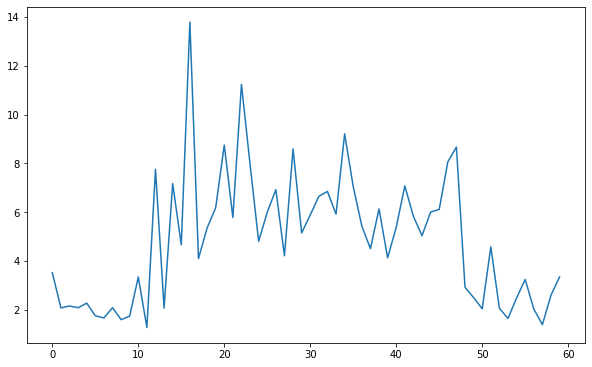

In [271]:
x = my_iter4_gamma
A_B = iter4
a_dot_x = A_B["a_all"].dot(x)
std_all = np.array([(np.dot(x, B).dot(x))**0.5 for B in A_B["b_all"]])
z = a_dot_x / std_all
plt.plot(z)

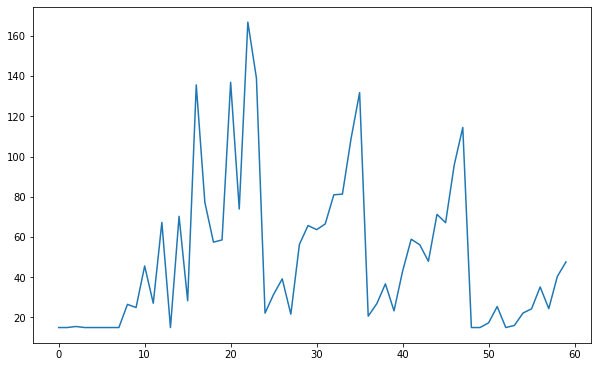

In [263]:
plt.plot(a_dot_x)

In [275]:
alpha = 0.8
mixed_x_iter4 = alpha * my_iter4_gamma  + (1 - alpha) * new_mode15_all_prime
np.savetxt("/Users/weilu/Research/server/oct_2020/membrane_protein_structure_prediction/gamma_folder/mixed_iter4.dat", mixed_x_iter4)

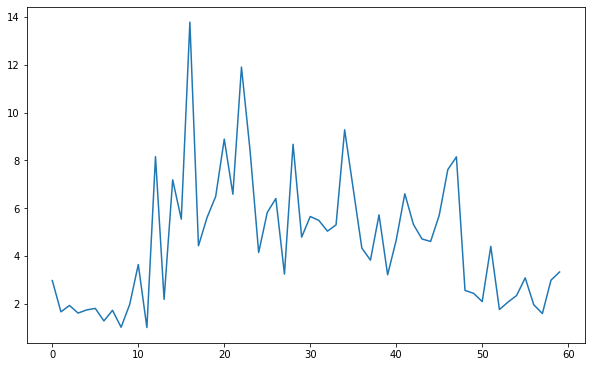

In [276]:
x = mixed_x_iter4
A_B = iter4
a_dot_x = A_B["a_all"].dot(x)
std_all = np.array([(np.dot(x, B).dot(x))**0.5 for B in A_B["b_all"]])
z = a_dot_x / std_all
plt.plot(z)

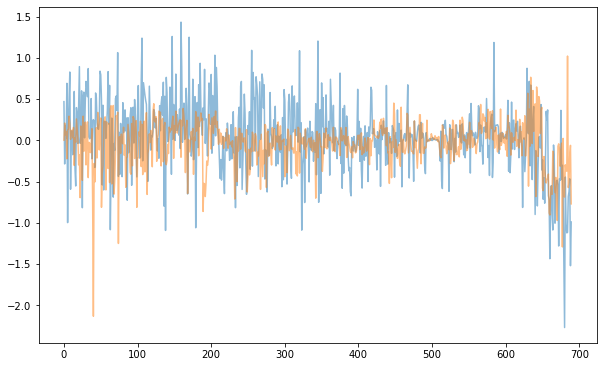

In [278]:
plt.plot(mixed_x_iter4, alpha=0.5)
plt.plot(new_mode15_all_prime, alpha=0.5)

In [159]:
pre = "/Users/weilu/Research/server/oct_2020/iterative_optimization/iteration1/gamma_iter3/"
iter3 = get_A_B(pre, n=690, all_ab=True)

In [149]:
A_B = iter3
cutoff_range=list(range(200, 700, 20)) 
gamma_iter3 = get_gamma(A_B['A'], A_B['B'], A_B['A_prime'], c=-66, cutoff_range=cutoff_range)

In [170]:
x = gamma_iter3[300]
A_B = iter3
a_dot_x = A_B["a_all"].dot(x)
std_all = np.array([(np.dot(x, B).dot(x))**0.5 for B in A_B["b_all"]])
z = a_dot_x / std_all

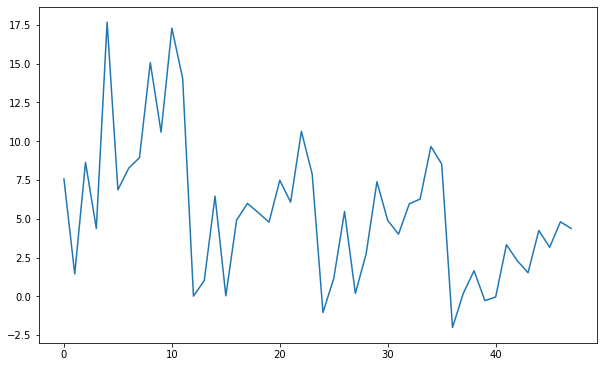

In [171]:
plt.plot(z)

In [172]:
B.shape

(690, 690)

In [173]:
from cvxopt import matrix, solvers
B_new = filter_B_matrix(iter3['B'], 300)

In [226]:
from cvxopt import matrix, solvers
B = B_new
A_B = iter3
A = A_B['A']
A_prime = A_B['A_prime']
n = len(A_prime)

Q = 2*matrix(B)
p = matrix(np.zeros(n))


# G = matrix(np.concatenate([-A.reshape(1,n), A_prime.reshape(1,n)]), (2,n))
# h = matrix([-100, -66], (2, 1), 'd')

# additional_constraint = np.diag([-1]*n)
additional_constraint = -a_all
n_additional_constraint = additional_constraint.shape[0]
G = matrix(np.concatenate([-A.reshape(1,n), A_prime.reshape(1,n), additional_constraint]), (2+n_additional_constraint,n))
h = matrix([-50, -66]+[-15]*n_additional_constraint, (2+n_additional_constraint, 1), 'd')

# additional_constraint = np.diag([-1]*n)
# additional_constraint2 = np.diag([1]*n)
# G = matrix(np.concatenate([-A.reshape(1,n), A_prime.reshape(1,n), 
#                            additional_constraint, additional_constraint2]), (2+n+n,n))
# h = matrix([-100, -66]+[2]*n+[2]*n, (2+n+n, 1), 'd')



sol=solvers.qp(Q, p, G=G, h=h)
x = np.array(sol['x']).flatten()

# additional_constraint = np.diag([-1]*n)
# additional_constraint = A_B_6nq0_A['A_prime'].reshape(1,n)
# additional_constraint = a_prime_all
# G = matrix(np.concatenate([-A.reshape(1,n), A_prime.reshape(1,n), additional_constraint]), (2+n,n))
# h = matrix([-21, -0]+[15]*n, (2+n, 1), 'd')
# G = matrix(np.concatenate([-A.reshape(1,n), A_prime.reshape(1,n), additional_constraint]), (2+1,n))
# h = matrix([-21, -0]+[-0], (2+1, 1), 'd')
# n_additional_constraint = additional_constraint.shape[0]
# G = matrix(np.concatenate([-A.reshape(1,n), A_prime.reshape(1,n), additional_constraint]), (2+n_additional_constraint,n))
# h = matrix([-21, -0]+[-0]*n_additional_constraint, (2+n_additional_constraint, 1), 'd')




     pcost       dcost       gap    pres   dres
 0:  1.1161e+02  1.3946e+02  3e+02  3e-01  5e+02
 1:  1.2239e+02  8.5396e+01  5e+01  5e-02  9e+01
 2:  1.1213e+02  9.4235e+01  2e+01  2e-02  4e+01
 3:  9.0351e+01  7.1554e+01  2e+01  1e-02  2e+01
 4:  8.4998e+01  8.1333e+01  4e+00  2e-04  4e-01
 5:  8.4280e+01  8.4097e+01  2e-01  9e-06  2e-02
 6:  8.4248e+01  8.4241e+01  6e-03  2e-07  3e-04
 7:  8.4247e+01  8.4247e+01  3e-04  2e-09  3e-06
 8:  8.4247e+01  8.4247e+01  4e-06  2e-11  3e-08
Optimal solution found.


In [227]:
compute_z(iter3, x)

5.782242551070044 8.647164065065606 50.000000003106166 -66.00000002019284


In [228]:
np.sum(abs(x))

206.05496715792637

In [229]:
np.sum(abs(new_mode15_all_prime))

133.34750949665136

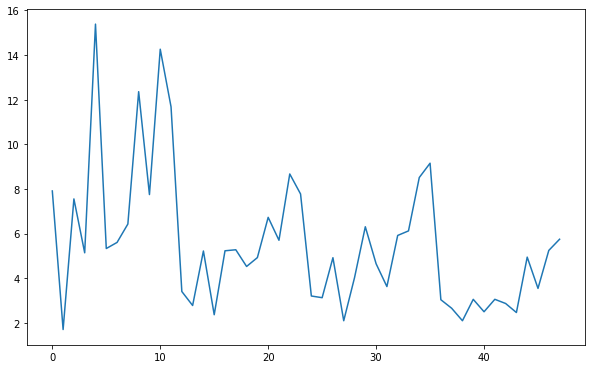

In [230]:
A_B = iter3
a_dot_x = A_B["a_all"].dot(x)
std_all = np.array([(np.dot(x, B).dot(x))**0.5 for B in A_B["b_all"]])
z = a_dot_x / std_all
# plt.plot(a_dot_x)
plt.plot(z)

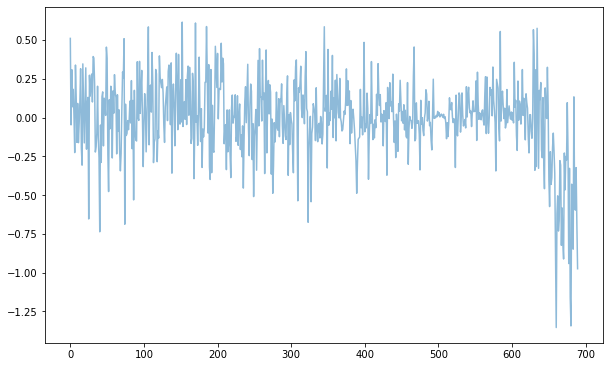

In [237]:
# plt.plot(x)
# plt.plot(new_mode15_all_prime, alpha=0.5)
plt.plot(mixed_x_iter3, alpha=0.5)

In [232]:
alpha = 0.5
mixed_x_iter3 = alpha * x  + (1 - alpha) * new_mode15_all_prime
np.savetxt("/Users/weilu/Research/server/oct_2020/membrane_protein_structure_prediction/gamma_folder/mixed_iter3.dat", mixed_x_iter3)

In [233]:
compute_z(iter3, mixed_x_iter3)

4.189200957081126 6.9688554512685 29.193935926214024 -66.40310552558529


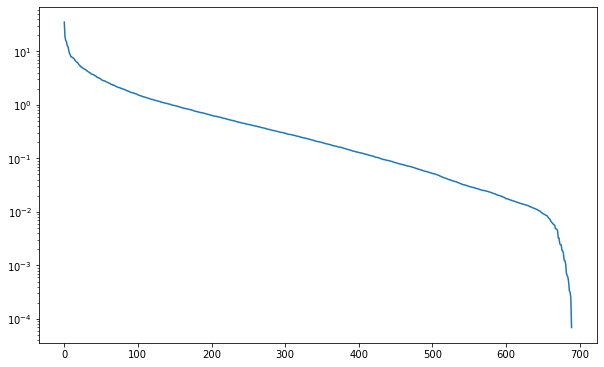

In [150]:
B = iter3['B']
lamb, P = np.linalg.eig(B)
lamb, P = sort_eigenvalues_and_eigenvectors(lamb, P)
plt.plot(lamb)
plt.yscale("log")

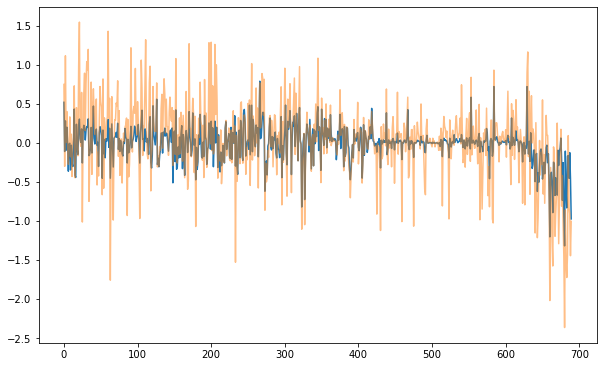

In [156]:
plt.plot(gamma_iter3[200])
plt.plot(gamma_iter3[400], alpha=0.5)

In [157]:
compute_z(iter3, new_mode15_all_prime)

0.9487865012842482 8.840631520334988 8.387871849321877 -66.80621103097776


In [153]:
compute_z(iter3, gamma_iter3[200])

5.166692958749333 6.392000669745112 33.02550485269309 -65.99999999999999


In [200]:
compute_z(iter3, gamma_iter3[300])

5.861481222642576 6.803176840606249 39.876693305530374 -66.00000000000003


In [154]:
compute_z(iter3, gamma_iter3[400])

6.549970481412646 7.251314446337471 47.49589557495152 -66.0


In [ ]:
compute_z(iter_mode20_decoy50_mixed_iter1_new_mode15_all_prime_version2_mixed_iter1_new_mode15_all_prime, x)

In [94]:
# iteration1/gamma_mode20_decoy50 is the same as optimization_specific_decoy_msa_submode_1/gamma
pre = "/Users/weilu/Research/server/oct_2020/iterative_optimization/iteration1/gamma_mode20_decoy50_mixed_iter1_new_mode15_all_prime_version2_mixed_iter1_new_mode15_all_prime//"
iter_mode20_decoy50_mixed_iter1_new_mode15_all_prime_version2_mixed_iter1_new_mode15_all_prime = get_A_B(pre, n=690)

In [97]:
A_B = iter_mode20_decoy50_mixed_iter1_new_mode15_all_prime_version2_mixed_iter1_new_mode15_all_prime
cutoff_range=list(range(400, 700, 20)) 
gamma_iter_mode20_decoy50_mixed_iter1_new_mode15_all_prime_version2_mixed_iter1_new_mode15_all_prime = get_gamma(A_B['A'], A_B['B'], A_B['A_prime'], c=-66, cutoff_range=cutoff_range)

In [98]:
compute_z(iter_mode20_decoy50_mixed_iter1_new_mode15_all_prime_version2_mixed_iter1_new_mode15_all_prime, gamma_iter_mode20_decoy50_mixed_iter1_new_mode15_all_prime_version2_mixed_iter1_new_mode15_all_prime[500])

7.25763899025436 7.787853644375062 56.52143025981096 -66.00000000000013


In [115]:
a_all = np.load("/Users/weilu/Research/server/oct_2020/iterative_optimization/iteration1/gamma_mode20_decoy50_mixed_iter1_new_mode15_all_prime_version2_mixed_iter1_new_mode15_all_prime/a_all.npy")
a_prime_all = np.load("/Users/weilu/Research/server/oct_2020/iterative_optimization/iteration1/gamma_mode20_decoy50_mixed_iter1_new_mode15_all_prime_version2_mixed_iter1_new_mode15_all_prime/a_prime_all.npy")
b_all = np.load("/Users/weilu/Research/server/oct_2020/iterative_optimization/iteration1/gamma_mode20_decoy50_mixed_iter1_new_mode15_all_prime_version2_mixed_iter1_new_mode15_all_prime/b_all.npy")

In [116]:
a_prime_all.dot(gamma_iter_mode20_decoy50_mixed_iter1_new_mode15_all_prime_version2_mixed_iter1_new_mode15_all_prime[500])

array([ -36.57545897,  -21.74543752,  -41.33288879,   -6.83645099,
        -46.26163361,  -68.73135068,  -99.15578996,  -46.13067296,
        -51.2201308 ,  -88.7378858 ,  -90.77489142,  -81.23850261,
        -35.05191804,  -17.29941976,  -37.6536099 ,   -7.29508025,
        -41.99264302,  -74.49425327,  -98.91951287,  -55.75103104,
        -44.92958765, -101.30891411,  -89.16625159,  -84.49576319,
        -43.48318093,  -31.93953763,  -48.51534236,  -13.70061327,
        -65.45204066, -111.79295746, -128.69681787,  -85.17578835,
        -83.19770857, -125.11787791, -124.09957229, -147.72948389])

In [107]:
a_all.dot(gamma_iter_mode20_decoy50_mixed_iter1_new_mode15_all_prime_version2_mixed_iter1_new_mode15_all_prime[500])

array([ 17.48177654,  29.59091786,  49.00777044,  14.5283804 ,
        45.31515669,  89.9017817 ,  67.72140495,  67.4399377 ,
       109.68601623,  75.92272983, 124.89295251, 141.54615117,
        16.56766937,  28.06602355,  47.61474104,  15.44675704,
        39.73975283,  84.97543424,  65.74385368,  56.03429626,
       108.17917793,  63.96353519, 114.15225299, 134.53593518,
        11.56619159,  14.67281544,  29.14667202,  13.68592308,
        12.57115585,  39.5012056 ,  35.88748338,  25.55356284,
        74.2553443 ,  33.48534996,  64.19313116,  72.19824881])

In [110]:
x = gamma_iter_mode20_decoy50_mixed_iter1_new_mode15_all_prime_version2_mixed_iter1_new_mode15_all_prime[500]
std_all = np.array([(np.dot(x, B).dot(x))**0.5 for B in b_all])

In [113]:
std_all

array([ 4.50871242,  4.59880435,  5.56747682,  3.81458499,  6.29849729,
       10.66122125, 10.33796553,  9.33844296,  8.49244459,  9.82089512,
       10.4729461 , 12.3512266 ,  4.34375804,  4.85440233,  5.31851921,
        3.75159407,  6.67546385,  8.19687631,  8.36089654,  8.11386459,
        8.37875817,  8.35910044,  9.56791487, 10.27239138,  4.41264777,
        5.0084133 ,  6.22846394,  4.2213952 ,  5.73387559,  8.22080989,
        8.5102417 ,  7.11101736,  8.89021074,  8.00365556,  8.67778407,
       10.28257693])

In [111]:
a_all.dot(gamma_iter_mode20_decoy50_mixed_iter1_new_mode15_all_prime_version2_mixed_iter1_new_mode15_all_prime[500]) / std_all

array([ 3.87733236,  6.43448071,  8.80251   ,  3.80863985,  7.1945981 ,
        8.43259694,  6.5507478 ,  7.22175399, 12.91571761,  7.7307342 ,
       11.92529317, 11.4600886 ,  3.81413265,  5.78156107,  8.9526312 ,
        4.11738497,  5.95310734, 10.36680694,  7.86325406,  6.90599351,
       12.91112307,  7.65196394, 11.93073459, 13.0968467 ,  2.62114544,
        2.92963351,  4.67959232,  3.24203787,  2.1924361 ,  4.80502604,
        4.21697581,  3.59351715,  8.35248415,  4.183757  ,  7.39741052,
        7.02141587])

In [114]:
from cvxopt import matrix, solvers
B_new = filter_B_matrix(iter_mode20_decoy50_mixed_iter1_new_mode15_all_prime_version2_mixed_iter1_new_mode15_all_prime['B'], 500)

In [125]:
from cvxopt import matrix, solvers
B = B_new
A_B = iter_mode1
A = A_B['A']
A_prime = A_B['A_prime']
n = len(A_prime)

Q = 2*matrix(B)
p = matrix(np.zeros(n))


# G = matrix(np.concatenate([-A.reshape(1,n), A_prime.reshape(1,n)]), (2,n))
# h = matrix([-100, -66], (2, 1), 'd')

# additional_constraint = np.diag([-1]*n)
additional_constraint = -a_all
n_additional_constraint = additional_constraint.shape[0]
G = matrix(np.concatenate([-A.reshape(1,n), A_prime.reshape(1,n), additional_constraint]), (2+n_additional_constraint,n))
h = matrix([-100, -66]+[-50]*n_additional_constraint, (2+n_additional_constraint, 1), 'd')

# additional_constraint = np.diag([-1]*n)
# additional_constraint2 = np.diag([1]*n)
# G = matrix(np.concatenate([-A.reshape(1,n), A_prime.reshape(1,n), 
#                            additional_constraint, additional_constraint2]), (2+n+n,n))
# h = matrix([-100, -66]+[2]*n+[2]*n, (2+n+n, 1), 'd')



sol=solvers.qp(Q, p, G=G, h=h)
x = np.array(sol['x']).flatten()

# additional_constraint = np.diag([-1]*n)
# additional_constraint = A_B_6nq0_A['A_prime'].reshape(1,n)
# additional_constraint = a_prime_all
# G = matrix(np.concatenate([-A.reshape(1,n), A_prime.reshape(1,n), additional_constraint]), (2+n,n))
# h = matrix([-21, -0]+[15]*n, (2+n, 1), 'd')
# G = matrix(np.concatenate([-A.reshape(1,n), A_prime.reshape(1,n), additional_constraint]), (2+1,n))
# h = matrix([-21, -0]+[-0], (2+1, 1), 'd')
# n_additional_constraint = additional_constraint.shape[0]
# G = matrix(np.concatenate([-A.reshape(1,n), A_prime.reshape(1,n), additional_constraint]), (2+n_additional_constraint,n))
# h = matrix([-21, -0]+[-0]*n_additional_constraint, (2+n_additional_constraint, 1), 'd')



     pcost       dcost       gap    pres   dres
 0:  1.0004e+02  2.5767e+03  7e+03  9e-01  2e+03
 1:  2.8981e+02 -2.0898e+02  5e+02  5e-02  9e+01
 2:  2.0785e+02  9.8830e+01  1e+02  5e-03  1e+01
 3:  1.5314e+02  1.4363e+02  1e+01  1e-15  1e-13
 4:  1.4853e+02  1.4784e+02  7e-01  1e-15  5e-13
 5:  1.4824e+02  1.4821e+02  3e-02  8e-16  1e-12
 6:  1.4823e+02  1.4823e+02  1e-03  9e-16  2e-11
 7:  1.4823e+02  1.4823e+02  2e-04  9e-16  4e-10
 8:  1.4823e+02  1.4823e+02  5e-06  1e-15  5e-10
Optimal solution found.


In [132]:
a_prime_all.dot(x)

array([ -46.65372543,  -33.60455226,  -71.453845  ,  -14.32012886,
        -72.19074539,  -64.90851641, -105.23820558,  -47.07619434,
        -41.86965824,  -98.76288049, -143.5323264 ,  -75.22388701,
        -45.40472988,  -32.8810696 ,  -71.29732077,  -18.56156324,
        -74.08126499, -102.86157847, -124.15462639,  -82.68034189,
        -67.06955643, -145.12154684, -160.29523867, -124.58571191,
        -51.74375231,  -44.8421731 ,  -72.55649942,  -26.11133975,
        -92.53095006, -139.0589186 , -151.97944544, -104.73892135,
       -110.09037644, -165.75378141, -181.78168949, -192.48810434])

In [126]:
a_all.dot(x)

array([ 53.25633221,  70.84955021,  71.11050955,  50.09006897,
        95.09959274, 133.32126237,  99.55510118, 111.63324998,
       121.73165193, 125.23098749, 132.30546689, 170.41420396,
        50.00000003,  59.42401574,  63.26254983,  50.00000001,
        75.22556367,  96.41356918,  77.92184882,  73.53425515,
        88.60376688,  79.70462089,  99.74782856, 116.91444232,
        50.00000003,  50.00000002,  50.00000002,  56.45295441,
        50.00000003,  50.00000007,  50.00000007,  50.00000007,
        50.00000056,  50.00000008,  59.04347417,  50.00000018])

In [127]:
std_all = np.array([(np.dot(x, B).dot(x))**0.5 for B in b_all])

In [128]:
std_all

array([ 7.52893774,  7.08755701,  9.34130783,  6.23340803, 10.25171736,
       16.47184618, 16.00778586, 14.35177754, 12.09490891, 15.80862312,
       15.66143563, 18.49298828,  7.67694545,  8.4079498 ,  7.77237192,
        7.06300061, 10.64140374, 12.1453248 , 12.06347744, 12.27891341,
       12.01833355, 12.81990011, 13.80688413, 14.66445643,  7.07317847,
        8.35452471,  8.81724463,  6.8342493 ,  8.73517363, 12.74100306,
       12.46483479, 11.70889485, 12.8016404 , 12.45206724, 13.23101744,
       15.37146774])

In [129]:
a_all.dot(x) / std_all

array([ 7.07355194,  9.99632879,  7.61247899,  8.03574365,  9.27645481,
        8.09388704,  6.21916747,  7.77835705, 10.06470184,  7.92168847,
        8.44785051,  9.21507121,  6.51300707,  7.06759877,  8.13941362,
        7.07914423,  7.06913914,  7.93832778,  6.45931898,  5.98866143,
        7.37238375,  6.21725756,  7.22449958,  7.97264071,  7.06895778,
        5.98478091,  5.67070577,  8.26030072,  5.72398468,  3.92433781,
        4.01128462,  4.27025784,  3.9057495 ,  4.01539753,  4.46250445,
        3.25277983])

In [130]:
compute_z(iter_mode20_decoy50_mixed_iter1_new_mode15_all_prime_version2_mixed_iter1_new_mode15_all_prime, x)

6.507670472745735 11.86995356710962 77.24574634154219 -88.81958794952756


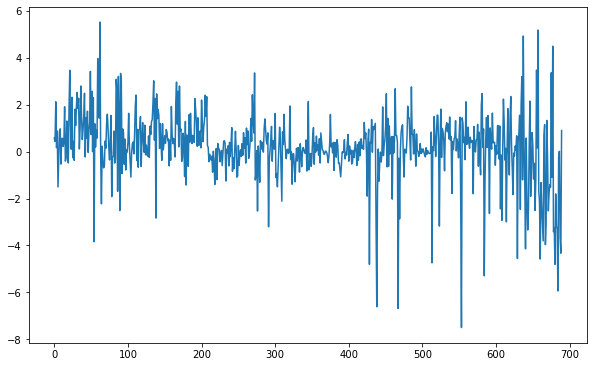

In [131]:
plt.plot(x)

In [134]:
alpha = 0.5
mixed_x_iter2 = alpha * x  + (1 - alpha) * new_mode15_all_prime
np.savetxt("/Users/weilu/Research/server/oct_2020/membrane_protein_structure_prediction/gamma_folder/mixed_iter2.dat", mixed_x_iter2)

In [133]:
compute_z(iter_mode20_decoy50_mixed_iter1_new_mode15_all_prime_version2_mixed_iter1_new_mode15_all_prime, new_mode15_all_prime)

-1.3093322819358955 8.289491146626816 -10.85369835910029 -86.196077863172


In [135]:
compute_z(iter_mode20_decoy50_mixed_iter1_new_mode15_all_prime_version2_mixed_iter1_new_mode15_all_prime, mixed_x_iter2)

4.701912413083064 7.060111094126948 33.19602399122095 -87.50783290634975


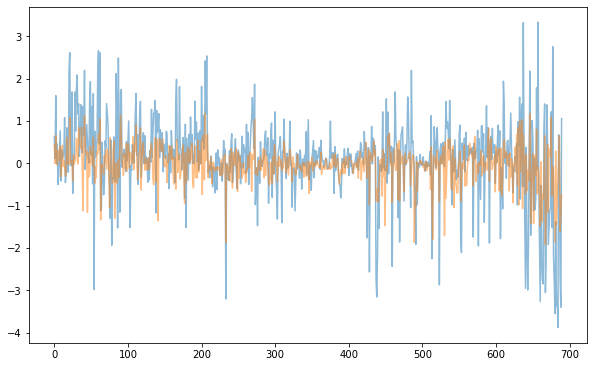

In [102]:
# plt.plot(gamma_iter_mode1[500], alpha=0.5)
plt.plot(gamma_iter_mode20_decoy50_mixed_iter1_new_mode15_all_prime_version2_mixed_iter1_new_mode15_all_prime[500], alpha=0.5)
plt.plot(mixed_x, alpha=0.5)

In [95]:
compute_z(iter_mode20_decoy50_mixed_iter1_new_mode15_all_prime_version2_mixed_iter1_new_mode15_all_prime, mixed_x)

0.7375357846960428 8.407561602970782 6.2008775442273745 -114.29212401960345


In [88]:
# iteration1/gamma_mode20_decoy50 is the same as optimization_specific_decoy_msa_submode_1/gamma
pre = "/Users/weilu/Research/server/oct_2020/iterative_optimization/iteration1/gamma_mode20_decoy50_mixed_iter1_new_mode15_all_prime/"
iter_mode20_decoy50_mixed_iter1_new_mode15_all_prime = get_A_B(pre, n=690)

In [90]:
A_B = iter_mode20_decoy50_mixed_iter1_new_mode15_all_prime
cutoff_range=list(range(400, 700, 20)) 
gamma_iter_mode20_decoy50_mixed_iter1_new_mode15_all_prime = get_gamma(A_B['A'], A_B['B'], A_B['A_prime'], c=-66, cutoff_range=cutoff_range)

In [93]:
compute_z(iter_mode20_decoy50_mixed_iter1_new_mode15_all_prime, gamma_iter_mode20_decoy50_mixed_iter1_new_mode15_all_prime[500])

11.097610572915631 10.916023517807288 121.14177800541383 -65.99999999999999


In [92]:
compute_z(iter_mode20_decoy50_mixed_iter1_new_mode15_all_prime, mixed_x)

3.595854702143376 7.1181371514491465 25.59578694653987 -95.21017845845722


In [83]:
# iteration1/gamma_mode20_decoy50 is the same as optimization_specific_decoy_msa_submode_1/gamma
pre = "/Users/weilu/Research/server/oct_2020/iterative_optimization/iteration1/gamma_mode20_decoy50/"
iter_mode20_decoy50 = get_A_B(pre, n=690)

In [85]:
abs(iter_mode20_decoy50['A'] - iter_mode1['A']).max()

2.220446049250313e-15

In [86]:
abs(iter_mode20_decoy50['B'] - iter_mode1['B']).max()

3.419486915845482e-14

In [4]:
pre = "/Users/weilu/Research/server/oct_2020/iterative_optimization/optimization_specific_decoy_msa_submode_1/gamma/"
iter_mode1 = get_A_B(pre, n=690)

In [17]:
from cvxopt import matrix, solvers
B_new = filter_B_matrix(iter_mode1['B'], 500)

In [59]:
from cvxopt import matrix, solvers
B = B_new
A_B = iter_mode1
A = A_B['A']
A_prime = A_B['A_prime']
n = len(A_prime)

Q = 2*matrix(B)
p = matrix(np.zeros(n))


G = matrix(np.concatenate([-A.reshape(1,n), A_prime.reshape(1,n)]), (2,n))
h = matrix([-100, -66], (2, 1), 'd')

# additional_constraint = np.diag([-1]*n)
# G = matrix(np.concatenate([-A.reshape(1,n), A_prime.reshape(1,n), additional_constraint]), (2+n,n))
# h = matrix([-100, -66]+[2]*n, (2+n, 1), 'd')

# additional_constraint = np.diag([-1]*n)
# additional_constraint2 = np.diag([1]*n)
# G = matrix(np.concatenate([-A.reshape(1,n), A_prime.reshape(1,n), 
#                            additional_constraint, additional_constraint2]), (2+n+n,n))
# h = matrix([-100, -66]+[2]*n+[2]*n, (2+n+n, 1), 'd')



sol=solvers.qp(Q, p, G=G, h=h)
x = np.array(sol['x']).flatten()

# additional_constraint = np.diag([-1]*n)
# additional_constraint = A_B_6nq0_A['A_prime'].reshape(1,n)
# additional_constraint = a_prime_all
# G = matrix(np.concatenate([-A.reshape(1,n), A_prime.reshape(1,n), additional_constraint]), (2+n,n))
# h = matrix([-21, -0]+[15]*n, (2+n, 1), 'd')
# G = matrix(np.concatenate([-A.reshape(1,n), A_prime.reshape(1,n), additional_constraint]), (2+1,n))
# h = matrix([-21, -0]+[-0], (2+1, 1), 'd')
# n_additional_constraint = additional_constraint.shape[0]
# G = matrix(np.concatenate([-A.reshape(1,n), A_prime.reshape(1,n), additional_constraint]), (2+n_additional_constraint,n))
# h = matrix([-21, -0]+[-0]*n_additional_constraint, (2+n_additional_constraint, 1), 'd')


     pcost       dcost       gap    pres   dres
 0:  3.7301e+01  3.7776e+01  8e-01  2e-02  2e-12
 1:  3.7773e+01  3.7778e+01  9e-03  2e-04  3e-14
 2:  3.7778e+01  3.7778e+01  9e-05  2e-06  3e-14
 3:  3.7778e+01  3.7778e+01  9e-07  2e-08  3e-14
Optimal solution found.


In [66]:
compute_z(iter_mode1, x)

16.686297685872216 5.992941106311298 99.99999931381069 -65.99999988728598


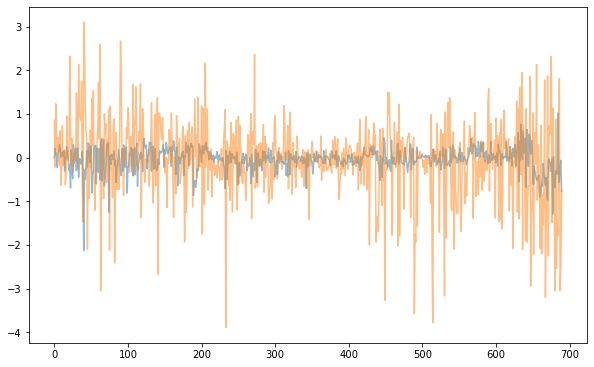

In [61]:
# plt.plot(gamma_iter_mode1[500], alpha=0.5)
plt.plot(new_mode15_all_prime, alpha=0.5)
plt.plot(x, alpha=0.5)

In [81]:
alpha = 0.5
mixed_x = alpha * x  + (1 - alpha) * new_mode15_all_prime
np.savetxt("/Users/weilu/Research/server/oct_2020/membrane_protein_structure_prediction/gamma_folder/version2_mixed_iter1_new_mode15_all_prime.dat", mixed_x)

In [79]:
compute_z(iter_mode1, mixed_x)

6.8192548052386535 5.514699815539656 37.60614321656751 -82.94453610588496


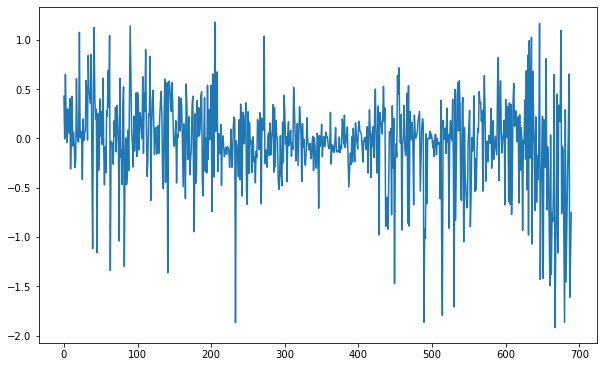

In [80]:
plt.plot(mixed_x)

In [5]:
A_B = iter_mode1
cutoff_range=list(range(400, 700, 20)) 
gamma_iter_mode1 = get_gamma(A_B['A'], A_B['B'], A_B['A_prime'], c=-66, cutoff_range=cutoff_range)

In [7]:
compute_z(iter_mode1, gamma_iter_mode1[500])

17.425247816194357 16.81843026163466 293.06531518836647 -66.00000000000001


In [11]:
compute_z(iter_mode1, new_mode15_all_prime)

-2.5828428550684577 9.597065819174153 -24.787712880675677 -99.88907232448393


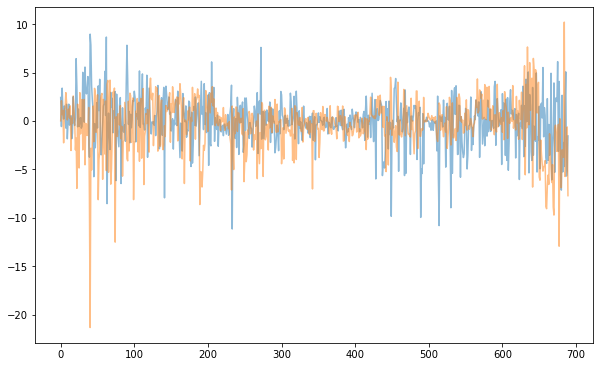

In [16]:
plt.plot(gamma_iter_mode1[500], alpha=0.5)
plt.plot(10*new_mode15_all_prime, alpha=0.5)

In [62]:

pre = "/Users/weilu/Research/server/oct_2020/iterative_optimization/mixed_iter1_new_mode15_all_prime_2/gamma/"
iter_mixed_iter1_new_mode15_all_prime_2 = get_A_B(pre, n=690)

In [63]:
A_B = iter_mixed_iter1_new_mode15_all_prime_2
cutoff_range=list(range(400, 700, 20)) 
gamma_iter_mixed_iter1_new_mode15_all_prime_2 = get_gamma(A_B['A'], A_B['B'], A_B['A_prime'], c=-66, cutoff_range=cutoff_range)

In [82]:
compute_z(iter_mixed_iter1_new_mode15_all_prime_2, mixed_x)

-0.26952483714666997 12.612551024248816 -3.3993957608147274 -103.52165008457447


In [65]:
compute_z(iter_mixed_iter1_new_mode15_all_prime_2, x)

-0.16411848863813935 22.6175059213435 -3.7119508885750627 -133.40069698889675


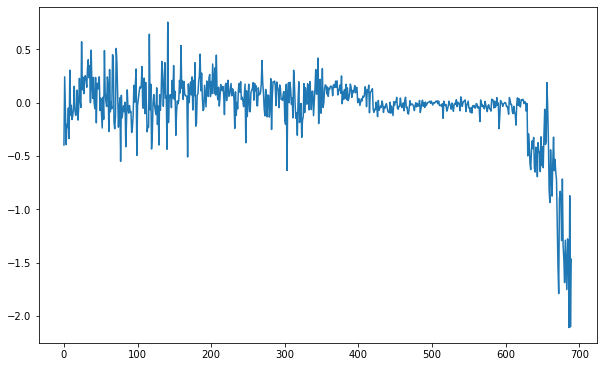

In [355]:
plt.plot(gamma_iter_mixed_iter1_new_mode15_all_prime_2[400])

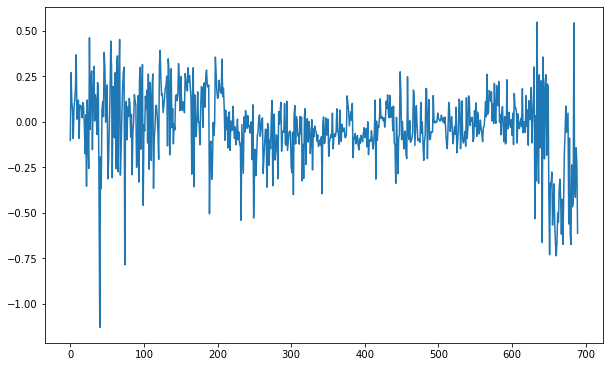

In [356]:
plt.plot(mixed_x)

In [354]:
compute_z(iter_mixed_iter1_new_mode15_all_prime_2, gamma_iter_mixed_iter1_new_mode15_all_prime_2[400])

3.416371128025681 5.857827104314473 20.012511392146244 -65.99999999999999


In [353]:
compute_z(iter_mixed_iter1_new_mode15_all_prime_2, mixed_x)

-0.5037822578924191 7.0321721966571475 -3.5426835871202305 -79.15891716771311


In [294]:
pre = "/Users/weilu/Research/server/oct_2020/iterative_optimization/optimization_specific_decoy_msa_submode_2/gamma/"
iter_mode2 = get_A_B(pre, n=690)

In [328]:
A_B = iter_mode2
cutoff_range=list(range(400, 700, 20)) 
gamma_iter_mode2 = get_gamma(A_B['A'], A_B['B'], A_B['A_prime'], c=-66, cutoff_range=cutoff_range)

In [329]:
# z score
A_B = iter_mode2
B = A_B["B"]
A = A_B["A"]
A_prime = A_B["A_prime"]
# x = gamma_mode16[722]
x = gamma_iter_mode2[400]
e_std = (np.dot(x, B).dot(x))**0.5
z = A.dot(x) / e_std
print(z, e_std, A.dot(x), A_prime.dot(x))

3.3710450304800084 4.953200562917806 16.69746214259485 -66.00000000000001


In [325]:
new_mode15_all_prime = np.loadtxt("/Users/weilu/Research/server/oct_2020/membrane_protein_structure_prediction/gamma_folder/new_mode15_all_prime.dat")

In [330]:
# z score
A_B = mode_15
B = A_B["B"]
A = A_B["A"]
A_prime = A_B["A_prime"]
# x = gamma_mode16[722]
# x = gamma_iter_mode2[400]
x = new_mode15_all_prime
e_std = (np.dot(x, B).dot(x))**0.5
z = A.dot(x) / e_std
print(z, e_std, A.dot(x), A_prime.dot(x))

4.44948869404758 4.719643411633881 21.000000000001105 -66.08984543497455


In [331]:
# z score
A_B = mode_15
B = A_B["B"]
A = A_B["A"]
A_prime = A_B["A_prime"]
# x = gamma_mode16[722]
x = gamma_iter_mode2[400]
# x = new_mode15_all_prime
e_std = (np.dot(x, B).dot(x))**0.5
z = A.dot(x) / e_std
print(z, e_std, A.dot(x), A_prime.dot(x))

0.7790097413219759 4.409387512537042 3.4349558255298316 -93.21033280789992


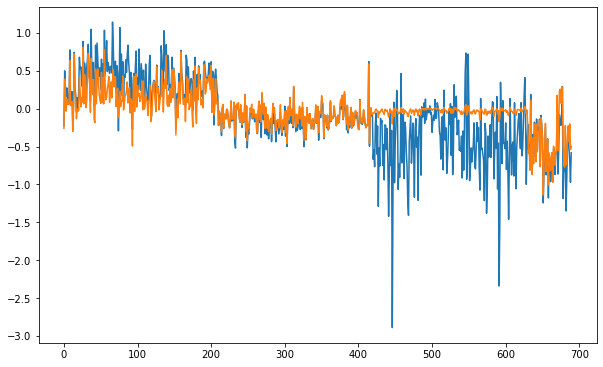

In [321]:
plt.plot(gamma_iter_mode2[500] )
plt.plot(gamma_iter_mode2[400] )

In [343]:
alpha = 0.4
mixed_x = alpha * gamma_iter_mode2[400]  + (1 - alpha) * new_mode15_all_prime

In [344]:
compute_z(iter_mode2, mixed_x)

0.954617463028819 6.249380250202495 5.965767519950711 -69.11502655446697


In [345]:
compute_z(mode_20_weighted, mixed_x)

0.9750980790897108 3.7928847762932736 3.6984346595721784 -88.5930206176874


In [347]:
compute_z(mode_15, mixed_x)

3.82921577028737 3.6493065861273974 13.973982330212595 -76.93804038414471


In [348]:
np.savetxt("/Users/weilu/Research/server/oct_2020/membrane_protein_structure_prediction/gamma_folder/mixed_iter1_new_mode15_all_prime.dat", mixed_x)

In [336]:
# z score
A_B = mode_15
B = A_B["B"]
A = A_B["A"]
A_prime = A_B["A_prime"]
# x = gamma_mode16[722]
# x = gamma_iter_mode2[400]
# x = new_mode15_all_prime
e_std = (np.dot(x, B).dot(x))**0.5
z = A.dot(x) / e_std
print(z, e_std, A.dot(x), A_prime.dot(x))

4.44948869404758 4.719643411633881 21.000000000001105 -66.08984543497455


In [339]:
# z score
A_B = mode_20_weighted
B = A_B["B"]
A = A_B["A"]
A_prime = A_B["A_prime"]
# x = gamma_mode16[722]
# x = gamma_iter_mode1[400]
# x = new_mode15_all_prime
# x = gamma_mode_20_weighted[600]
e_std = (np.dot(x, B).dot(x))**0.5
z = A.dot(x) / e_std
print(z, e_std, A.dot(x), A_prime.dot(x))

1.2348038863357502 5.265863960387635 6.502309283202017 -81.67709844922514


In [276]:
pre = "/Users/weilu/Research/server/oct_2020/iterative_optimization/optimization_specific_decoy_msa_submode_1/gamma/"
iter_mode1 = get_A_B(pre, n=690)

In [277]:
A_B = iter_mode1
cutoff_range=list(range(400, 700, 20)) 
gamma_iter_mode1 = get_gamma(A_B['A'], A_B['B'], A_B['A_prime'], c=-100, cutoff_range=cutoff_range)

In [280]:
# z score
A_B = iter_mode1
B = A_B["B"]
A = A_B["A"]
A_prime = A_B["A_prime"]
# x = gamma_mode16[722]
x = gamma_iter_mode1[400]
e_std = (np.dot(x, B).dot(x))**0.5
z = A.dot(x) / e_std
print(z, e_std, A.dot(x), A_prime.dot(x))

15.943918622372337 15.475615679570494 246.74195702618132 -99.99999999999999


In [291]:
alpha = 0.05
x = alpha * gamma_iter_mode1[400]  + (1 - alpha) * gamma_mode_20_weighted[600]

In [292]:
# z score
A_B = iter_mode1
B = A_B["B"]
A = A_B["A"]
A_prime = A_B["A_prime"]
# x = gamma_mode16[722]
# x = gamma_iter_mode1[400]
e_std = (np.dot(x, B).dot(x))**0.5
z = A.dot(x) / e_std
print(z, e_std, A.dot(x), A_prime.dot(x))

0.030300733463957705 5.841683421413757 0.17700729233307877 -94.76536650117568


In [293]:
# z score
A_B = mode_20_weighted
B = A_B["B"]
A = A_B["A"]
A_prime = A_B["A_prime"]
# x = gamma_mode16[722]
# x = gamma_iter_mode1[400]
e_std = (np.dot(x, B).dot(x))**0.5
z = A.dot(x) / e_std
print(z, e_std, A.dot(x), A_prime.dot(x))

0.5075052880027688 2.2537847471817183 1.1438076772147054 -113.59210746885668


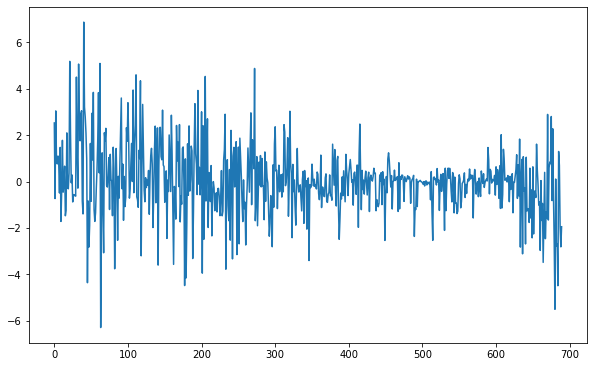

In [281]:
plt.plot(x)

In [278]:
# z score
A_B = iter_mode1
B = A_B["B"]
A = A_B["A"]
A_prime = A_B["A_prime"]
# x = gamma_mode16[722]
x = gamma_mode_20_weighted[600]
e_std = (np.dot(x, B).dot(x))**0.5
z = A.dot(x) / e_std
print(z, e_std, A.dot(x), A_prime.dot(x))

-2.094938783766158 6.110009239614448 -12.800095325237882 -94.48985947492179


# Using the Helix Swapping method

## weighted differently

In [265]:
pre = "/Users/weilu/Research/server/oct_2020/curated_single_chain_optimization/optimization_msa_submode_20/with_weighted_gamma/"
mode_20_weighted = get_A_B(pre, n=690)

In [266]:
A_B = mode_20_weighted
cutoff_range=list(range(400, 700, 20)) 
gamma_mode_20_weighted = get_gamma(A_B['A'], A_B['B'], A_B['A_prime'], c=-100, cutoff_range=cutoff_range)

In [267]:
# z score
A_B = mode_20_weighted
B = A_B["B"]
A = A_B["A"]
A_prime = A_B["A_prime"]
# x = gamma_mode16[722]
x = gamma_mode_20_weighted[600]
e_std = (np.dot(x, B).dot(x))**0.5
z = A.dot(x) / e_std
print(z, e_std, A.dot(x), A_prime.dot(x))

1.3131035441155132 1.766509739058924 2.3196101990728435 -100.00000000000004


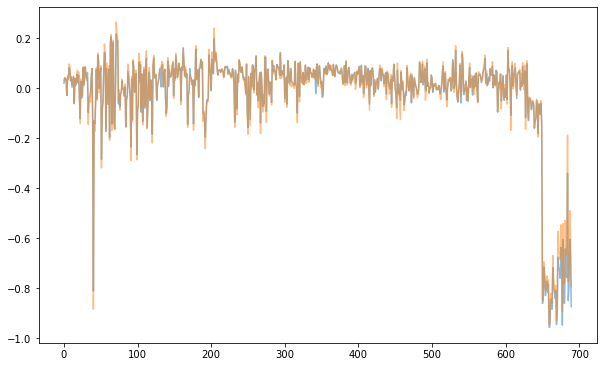

In [268]:
plt.plot(gamma_mode20[600][:690], alpha=0.5)
plt.plot(gamma_mode_20_weighted[600][:690], alpha=0.5)

## max swaping to 5

In [218]:
pre = "/Users/weilu/Research/server/oct_2020/curated_single_chain_optimization/optimization_msa_submode_20/gamma/"
mode_20 = get_A_B(pre, n=690)

In [241]:
A_B = mode_20
cutoff_range=list(range(400, 700, 20)) 
gamma_mode20 = get_gamma(A_B['A'], A_B['B'], A_B['A_prime'], c=-100, cutoff_range=cutoff_range)

In [242]:
# z score
A_B = mode_20
B = A_B["B"]
A = A_B["A"]
A_prime = A_B["A_prime"]
# x = gamma_mode16[722]
x = gamma_mode20[600]
e_std = (np.dot(x, B).dot(x))**0.5
z = A.dot(x) / e_std
print(z, e_std, A.dot(x), A_prime.dot(x))

1.1476418718153238 1.6652828073438704 1.9111482781219966 -99.99999999999999


In [239]:
x = np.loadtxt("/Users/weilu/opt/parameters/original_membrane_gamma")

In [240]:
# z score
A_B = mode_20
B = A_B["B"]
A = A_B["A"]
A_prime = A_B["A_prime"]
# x = gamma_mode16[722]
# x = gamma_mode20[600]
e_std = (np.dot(x, B).dot(x))**0.5
z = A.dot(x) / e_std
print(z, e_std, A.dot(x), A_prime.dot(x))

0.4147311331317683 10.0790489399915 4.180095387773223 -215.44066219737485


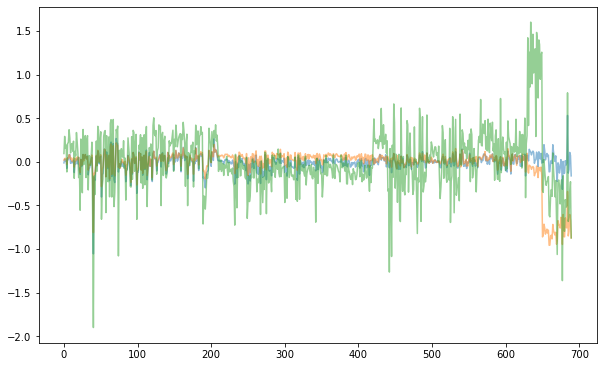

In [243]:
plt.plot(gamma_mode18[600][:690], alpha=0.5)
plt.plot(gamma_mode20[600][:690], alpha=0.5)
plt.plot(gamma_mode15[600][:690], alpha=0.5)
# plt.plot(gamma_mode16[722][:690], alpha=0.5)

In [244]:
B = mode_20['B']
cutoff = 600
lamb, P = np.linalg.eig(B)
lamb, P = sort_eigenvalues_and_eigenvectors(lamb, P)
filtered_lamb = np.copy(lamb)
cutoff_mode = cutoff
filtered_B_inv, filtered_lamb, P = get_filtered_B_inv_lambda_and_P(filtered_lamb,
                                                                   cutoff_mode, P)
B_new = np.linalg.inv(filtered_B_inv)

In [245]:
abFile = "/Users/weilu/Research/server/oct_2020/curated_single_chain_optimization/optimization_msa_submode_20/a_prime_all.npy"
a_prime_all_mode20 = np.load(abFile, allow_pickle=True)
abFile = "/Users/weilu/Research/server/oct_2020/curated_single_chain_optimization/optimization_msa_submode_20/a_all.npy"
a_all_mode20 = np.load(abFile, allow_pickle=True)

In [254]:
from cvxopt import matrix, solvers
A_B = mode_20
# B = A_B['B']
B = B_new
A = A_B['A']
A_prime = A_B['A_prime']
n = len(A_prime)

Q = 2*matrix(B)
p = matrix(np.zeros(n))
# G = matrix(-A, (1,n))
# h = matrix(-7.117566, (1, 1), 'd')
# additional_constraint = np.diag([-1]*n)
# additional_constraint = A_B_6nq0_A['A_prime'].reshape(1,n)
additional_constraint = a_prime_all_mode20
# additional_constraint = -a_all_mode18
# G = matrix(np.concatenate([-A.reshape(1,n), A_prime.reshape(1,n), additional_constraint]), (2+n,n))
# h = matrix([-21, -0]+[15]*n, (2+n, 1), 'd')
# G = matrix(np.concatenate([-A.reshape(1,n), A_prime.reshape(1,n), additional_constraint]), (2+1,n))
# h = matrix([-21, -0]+[-0], (2+1, 1), 'd')
n_additional_constraint = additional_constraint.shape[0]
G = matrix(np.concatenate([-A.reshape(1,n), A_prime.reshape(1,n), additional_constraint]), (2+n_additional_constraint,n))
h = matrix([-10, -50]+[-0]*n_additional_constraint, (2+n_additional_constraint, 1), 'd')
sol=solvers.qp(Q, p, G=G, h=h)
x = np.array(sol['x']).flatten()

     pcost       dcost       gap    pres   dres
 0:  1.2881e+00  2.6033e+03  7e+04  3e+01  9e+04
 1:  4.2743e+01 -1.7341e+04  4e+04  2e+01  5e+04
 2:  1.0048e+02 -4.0736e+03  5e+03  2e+00  6e+03
 3:  6.0374e+01 -9.2565e+02  1e+03  5e-01  1e+03
 4:  5.3607e+01 -3.2300e+01  9e+01  4e-02  1e+02
 5:  5.2699e+01  4.4668e+01  8e+00  3e-03  9e+00
 6:  5.2401e+01  5.1287e+01  1e+00  3e-04  8e-01
 7:  5.2726e+01  5.1662e+01  1e+00  2e-04  5e-01
 8:  5.2378e+01  5.2285e+01  9e-02  1e-06  4e-03
 9:  5.2353e+01  5.2351e+01  1e-03  2e-08  5e-05
10:  5.2352e+01  5.2352e+01  1e-05  2e-10  5e-07
11:  5.2352e+01  5.2352e+01  1e-07  2e-12  5e-09
Optimal solution found.


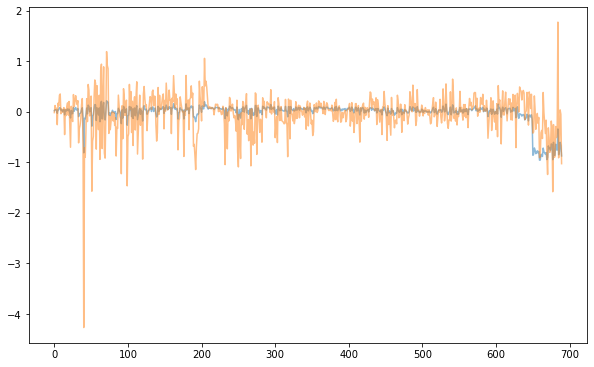

In [255]:
plt.plot(gamma_mode20[600][:690], alpha=0.5)
plt.plot(x, alpha=0.5)

In [256]:
# z score
A_B = mode_20
B = A_B["B"]
A = A_B["A"]
A_prime = A_B["A_prime"]
# x = gamma_mode16[722]
# x = gamma_mode20[600]
e_std = (np.dot(x, B).dot(x))**0.5
z = A.dot(x) / e_std
print(z, e_std, A.dot(x), A_prime.dot(x))

1.3832367889441166 7.229420212019691 10.000000000001812 -50.00000202942445


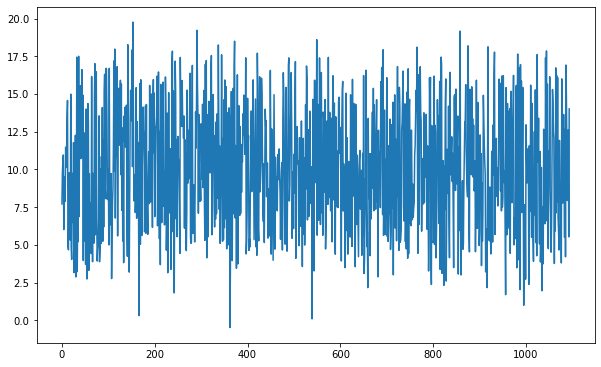

In [257]:
e_decoys = a_all_mode20.dot(x)
plt.plot(e_decoys)

In [ ]:
e_decoys = a_all_mode20.dot(x)
plt.plot(e_decoys)

In [258]:
np.savetxt("/Users/weilu/Research/server/oct_2020/membrane_protein_structure_prediction/gamma_folder/mode20_decoy50.dat", x)

## with four body term

In [142]:
pre = "/Users/weilu/Research/server/oct_2020/curated_single_chain_optimization/optimization_msa_submode_19/gamma/"
mode_19 = get_A_B(pre, n=2022)

In [143]:
A_B = mode_19
cutoff_range=list(range(522, 2122, 100)) 
gamma_mode19 = get_gamma(A_B['A'], A_B['B'], A_B['A_prime'], c=-0, cutoff_range=cutoff_range)

In [144]:
# z score
B = A_B["B"]
A = A_B["A"]
A_prime = A_B["A_prime"]
# x = gamma_mode16[722]
x = gamma_mode19[722]
e_std = (np.dot(x, B).dot(x))**0.5
z = A.dot(x) / e_std
print(z, e_std, A.dot(x), A_prime.dot(x))

1.7952686649207632 1.7255169560688408 3.097766522019847 -4.1639380745500665e-14


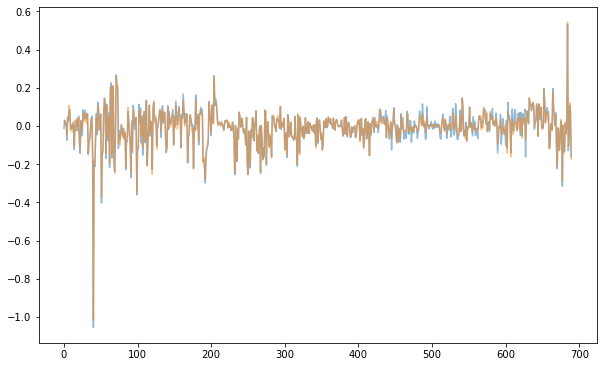

In [146]:
plt.plot(gamma_mode18[600][:690], alpha=0.5)
plt.plot(gamma_mode19[722][:690], alpha=0.5)
# plt.plot(gamma_mode16[722][:690], alpha=0.5)

In [154]:
# z score
A_B = mode_19
B = A_B["B"][:690,:690]
A = A_B["A"][:690]
A_prime = A_B["A_prime"][:690]
# x = gamma_mode16[722]
# x = gamma_mode18[600]
x = gamma_mode19[722][:690]
e_std = (np.dot(x, B).dot(x))**0.5
z = A.dot(x) / e_std
print(z, e_std, A.dot(x), A_prime.dot(x))

1.555612371954856 1.480976308964884 2.303825068797811 -0.31545550522174765


## multi swapping

In [127]:
pre = "/Users/weilu/Research/server/oct_2020/curated_single_chain_optimization/optimization_msa_submode_18/gamma/"
mode_18 = get_A_B(pre, n=690)

In [128]:
A_B = mode_18
cutoff_range=list(range(400, 700, 20)) 
gamma_mode18 = get_gamma(A_B['A'], A_B['B'], A_B['A_prime'], c=-0, cutoff_range=cutoff_range)

In [200]:
# z score
A_B = mode_18
B = A_B["B"]
A = A_B["A"]
A_prime = A_B["A_prime"]
# x = gamma_mode16[722]
x = gamma_mode18[600]
e_std = (np.dot(x, B).dot(x))**0.5
z = A.dot(x) / e_std
print(z, e_std, A.dot(x), A_prime.dot(x))

1.6023974535297358 1.6017464202657083 2.566634385034141 2.4313884239290928e-14


In [136]:
A_B = mode_15
# z score
B = A_B["B"]
A = A_B["A"]
A_prime = A_B["A_prime"]
# x = gamma_mode16[722]
x = gamma_mode18[600]
# x = gamma_mode17[600]
e_std = (np.dot(x, B).dot(x))**0.5
z = A.dot(x) / e_std
print(z, e_std, A.dot(x), A_prime.dot(x))

3.3666541002619708 1.6024120120471539 5.394766970667585 2.879431372056806


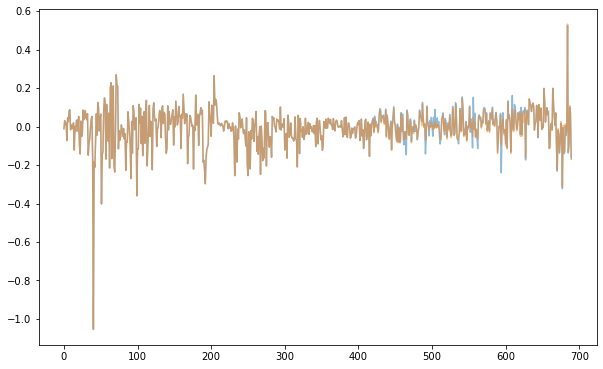

In [180]:
plt.plot(gamma_mode18[680][:690], alpha=0.5)
plt.plot(gamma_mode18[600][:690], alpha=0.5)

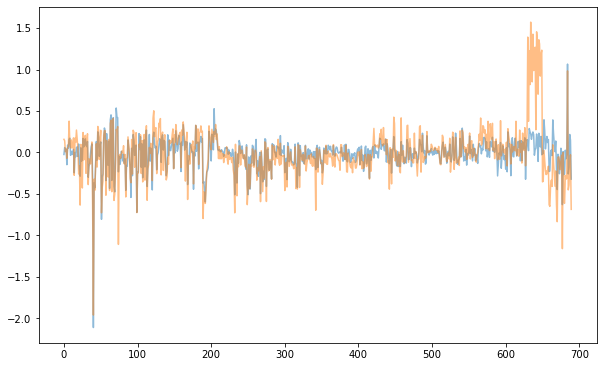

In [206]:
plt.plot(2*gamma_mode18[600][:690], alpha=0.5)
# plt.plot(2*gamma_mode17[600][:690], alpha=0.5)
plt.plot(gamma_mode16[722][:690], alpha=0.5)

In [156]:
abFile = "/Users/weilu/Research/server/oct_2020/curated_single_chain_optimization/optimization_msa_submode_18/a_prime_all.npy"
a_prime_all_mode18 = np.load(abFile, allow_pickle=True)
abFile = "/Users/weilu/Research/server/oct_2020/curated_single_chain_optimization/optimization_msa_submode_18/a_all.npy"
a_all_mode18 = np.load(abFile, allow_pickle=True)

In [181]:
B = mode_18['B']
cutoff = 600
lamb, P = np.linalg.eig(B)
lamb, P = sort_eigenvalues_and_eigenvectors(lamb, P)
filtered_lamb = np.copy(lamb)
cutoff_mode = cutoff
filtered_B_inv, filtered_lamb, P = get_filtered_B_inv_lambda_and_P(filtered_lamb,
                                                                   cutoff_mode, P)
B_new = np.linalg.inv(filtered_B_inv)

In [207]:
from cvxopt import matrix, solvers
A_B = mode_18
# B = A_B['B']
B = B_new
A = A_B['A']
A_prime = A_B['A_prime']
n = len(A_prime)

Q = 2*matrix(B)
p = matrix(np.zeros(n))
# G = matrix(-A, (1,n))
# h = matrix(-7.117566, (1, 1), 'd')
# additional_constraint = np.diag([-1]*n)
# additional_constraint = A_B_6nq0_A['A_prime'].reshape(1,n)
additional_constraint = a_prime_all_mode18
# additional_constraint = -a_all_mode18
# G = matrix(np.concatenate([-A.reshape(1,n), A_prime.reshape(1,n), additional_constraint]), (2+n,n))
# h = matrix([-21, -0]+[15]*n, (2+n, 1), 'd')
# G = matrix(np.concatenate([-A.reshape(1,n), A_prime.reshape(1,n), additional_constraint]), (2+1,n))
# h = matrix([-21, -0]+[-0], (2+1, 1), 'd')
n_additional_constraint = additional_constraint.shape[0]
G = matrix(np.concatenate([-A.reshape(1,n), A_prime.reshape(1,n), additional_constraint]), (2+n_additional_constraint,n))
h = matrix([-2.57, -0]+[-0]*n_additional_constraint, (2+n_additional_constraint, 1), 'd')
sol=solvers.qp(Q, p, G=G, h=h)
x = np.array(sol['x']).flatten()

     pcost       dcost       gap    pres   dres
 0:  7.6950e-02  9.0717e+00  4e+03  5e+01  9e+04
 1:  1.3418e+01 -8.4706e+02  1e+03  1e+01  2e+04
 2:  8.0611e+00 -1.4474e+02  2e+02  1e+00  3e+03
 3:  4.3865e+00 -3.4904e+01  4e+01  3e-01  6e+02
 4:  2.9660e+00 -1.0867e+01  1e+01  1e-01  2e+02
 5:  2.6303e+00  1.0500e+00  2e+00  1e-02  2e+01
 6:  2.5980e+00  2.2898e+00  3e-01  2e-03  3e+00
 7:  2.5865e+00  2.5246e+00  6e-02  3e-04  6e-01
 8:  2.5864e+00  2.5471e+00  4e-02  2e-04  3e-01
 9:  2.5843e+00  2.5769e+00  7e-03  3e-05  5e-02
10:  2.5841e+00  2.5839e+00  2e-04  2e-07  5e-04
11:  2.5841e+00  2.5841e+00  2e-06  2e-09  5e-06
12:  2.5841e+00  2.5841e+00  2e-08  2e-11  5e-08
Optimal solution found.


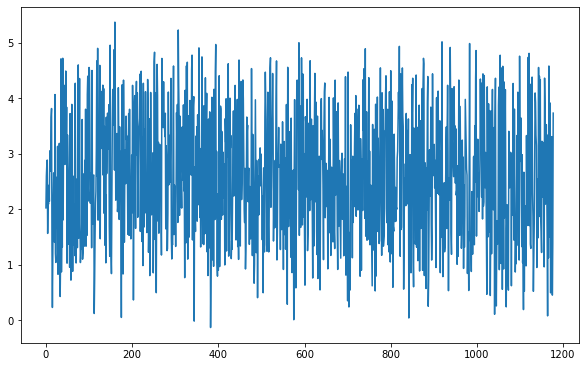

In [208]:
e_decoys = a_all_mode18.dot(x)
plt.plot(e_decoys)

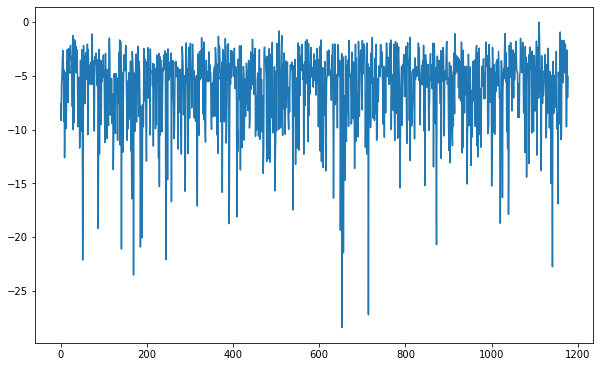

In [211]:
e_decoys = a_prime_all_mode18.dot(x)
plt.plot(e_decoys)

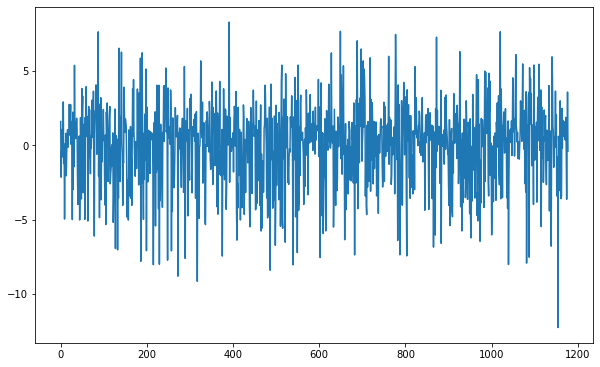

In [213]:
e_decoys = a_prime_all_mode18.dot(gamma_mode18[600])
plt.plot(e_decoys)

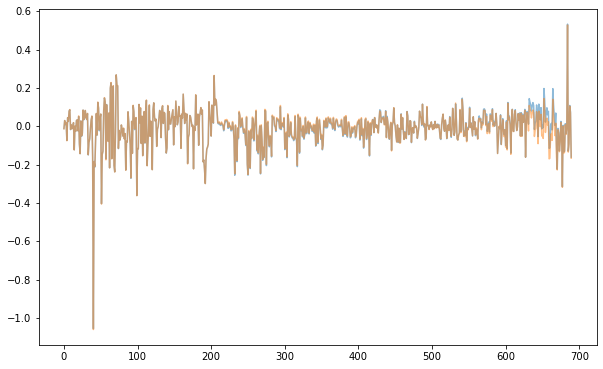

In [209]:
plt.plot(gamma_mode18[600][:690], alpha=0.5)
plt.plot(x, alpha=0.5)

In [214]:
# z score
A_B = mode_18
B = A_B["B"]
A = A_B["A"]
A_prime = A_B["A_prime"]
# x = gamma_mode16[722]
# x = gamma_mode18[600]
e_std = (np.dot(x, B).dot(x))**0.5
z = A.dot(x) / e_std
print(z, e_std, A.dot(x), A_prime.dot(x))

1.59911593104235 1.6071380130330029 2.5700000000248227 -6.116724433643385


In [215]:
np.savetxt("/Users/weilu/Research/server/oct_2020/membrane_protein_structure_prediction/gamma_folder/mode18.dat", 2*x)

## single swap

In [95]:
pre = "/Users/weilu/Research/server/oct_2020/curated_single_chain_optimization/optimization_msa_submode_17/gamma/"
mode_17 = get_A_B(pre, n=690)

In [96]:
A_B = mode_17
cutoff_range=list(range(400, 700, 20)) 
gamma_mode17 = get_gamma(A_B['A'], A_B['B'], A_B['A_prime'], c=-0, cutoff_range=cutoff_range)

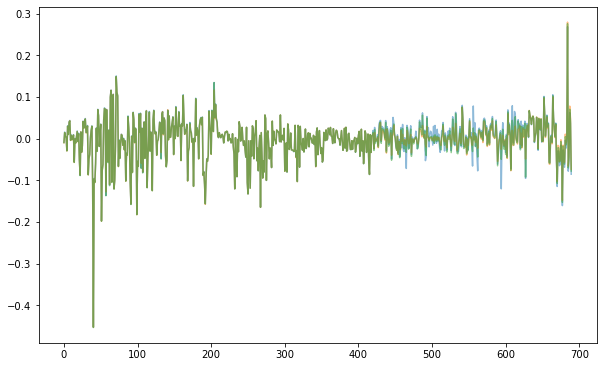

In [109]:
plt.plot(gamma_mode17[680][:690], alpha=0.5)
plt.plot(gamma_mode17[520][:690], alpha=0.5)
plt.plot(gamma_mode17[600][:690], alpha=0.5)

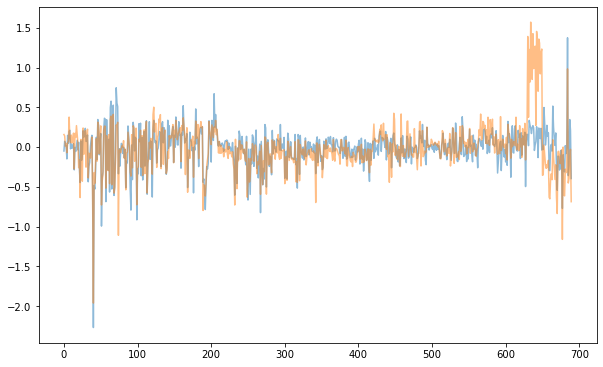

In [107]:
plt.plot(5* gamma_mode17[620][:690], alpha=0.5)
plt.plot(gamma_mode16[722][:690], alpha=0.5)
# plt.plot(gamma_mode15[520][:690])

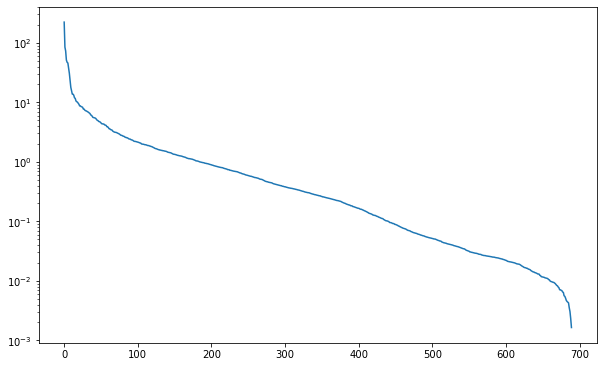

In [108]:
B = A_B['B']
lamb, P = np.linalg.eig(B)
lamb, P = sort_eigenvalues_and_eigenvectors(lamb, P)
plt.plot(lamb)
plt.yscale("log")

In [105]:
# z score
B = A_B["B"]
A = A_B["A"]
A_prime = A_B["A_prime"]
# x = gamma_mode16[722]
x = gamma_mode17[520]
e_std = (np.dot(x, B).dot(x))**0.5
z = A.dot(x) / e_std
print(z, e_std, A.dot(x), A_prime.dot(x))

0.7951810888197598 0.7940091516131166 0.6313810617125718 3.0531133177191805e-15


In [106]:
# z score
B = A_B["B"]
A = A_B["A"]
A_prime = A_B["A_prime"]
# x = gamma_mode16[722]
x = gamma_mode17[680]
e_std = (np.dot(x, B).dot(x))**0.5
z = A.dot(x) / e_std
print(z, e_std, A.dot(x), A_prime.dot(x))

0.795753389886715 0.7957250352781431 0.6332008942403082 2.7255975254547593e-14


In [111]:
B = mode_17['B']
cutoff = 600
lamb, P = np.linalg.eig(B)
lamb, P = sort_eigenvalues_and_eigenvectors(lamb, P)
filtered_lamb = np.copy(lamb)
cutoff_mode = cutoff
filtered_B_inv, filtered_lamb, P = get_filtered_B_inv_lambda_and_P(filtered_lamb,
                                                                   cutoff_mode, P)
B_new = np.linalg.inv(filtered_B_inv)

In [124]:
from cvxopt import matrix, solvers
A_B = mode_17
# B = A_B['B']
B = B_new
A = A_B['A']
A_prime = A_B['A_prime']
n = len(A_prime)

Q = 2*matrix(B)
p = matrix(np.zeros(n))

n_additional_constraint = additional_constraint.shape[0]
G = matrix(np.concatenate([-A.reshape(1,n), A_prime.reshape(1,n)]), (2,n))
h = matrix([-3, -0], (2, 1), 'd')
sol=solvers.qp(Q, p, G=G, h=h)
x = np.array(sol['x']).flatten()

     pcost       dcost       gap    pres   dres
 0:  8.2154e-01  6.0156e+00  2e+00  2e+00  1e-13
 1:  6.0180e+00  1.2486e+01  3e+00  7e-01  5e-14
 2:  1.7155e+01  1.1906e+01  5e+00  9e-15  2e-13
 3:  1.4642e+01  1.3917e+01  7e-01  1e-14  2e-13
 4:  1.4293e+01  1.4189e+01  1e-01  3e-15  6e-13
 5:  1.4236e+01  1.4222e+01  1e-02  2e-15  1e-12
 6:  1.4227e+01  1.4225e+01  1e-03  1e-15  3e-12
 7:  1.4225e+01  1.4225e+01  3e-05  3e-15  7e-12
 8:  1.4225e+01  1.4225e+01  3e-07  2e-15  2e-11
Optimal solution found.


In [125]:
# z score
B = A_B["B"]
A = A_B["A"]
A_prime = A_B["A_prime"]
# x = gamma_mode16[722]
# x = gamma_mode17[680]
e_std = (np.dot(x, B).dot(x))**0.5
z = A.dot(x) / e_std
print(z, e_std, A.dot(x), A_prime.dot(x))

0.7955802160094607 3.7708328340043202 3.000000000612724 -0.00017400906743603173


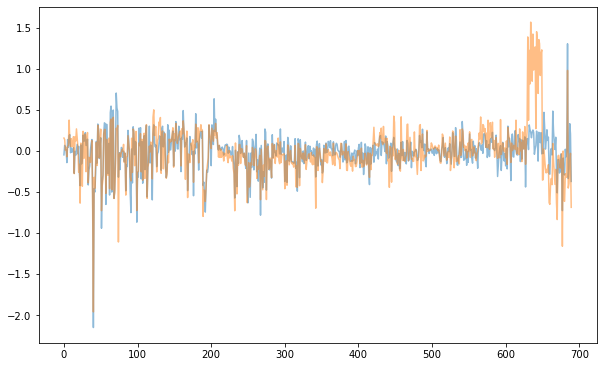

In [126]:
plt.plot(x, alpha=0.5)
# plt.plot(gamma_mode17[620][:690], alpha=0.5)
plt.plot(gamma_mode16[722][:690], alpha=0.5)
# plt.plot(gamma_mode15[520][:690])

In [84]:
pre = "/Users/weilu/Research/server/oct_2020/curated_single_chain_optimization/optimization_msa_submode_16/gamma/"
mode_16 = get_A_B(pre, n=2022)

In [85]:
abFile = "/Users/weilu/Research/server/oct_2020/curated_single_chain_optimization/optimization_msa_submode_16/a_prime_all.npy"
a_prime_all_mode16 = np.load(abFile, allow_pickle=True)

In [86]:
A_B = mode_16
cutoff_range=list(range(522, 2122, 100)) 
gamma_mode16 = get_gamma(A_B['A'], A_B['B'], A_B['A_prime'], c=-0, cutoff_range=cutoff_range)

In [87]:
# z score
B = A_B["B"]
A = A_B["A"]
A_prime = A_B["A_prime"]
x = gamma_mode16[722]
e_std = (np.dot(x, B).dot(x))**0.5
z = A.dot(x) / e_std
print(z, e_std, A.dot(x), A_prime.dot(x))

5.006197747326388 4.816455992909468 24.11213114180006 2.372545519421787e-13


In [88]:
B = mode_16['B']
cutoff = 722
lamb, P = np.linalg.eig(B)
lamb, P = sort_eigenvalues_and_eigenvectors(lamb, P)
filtered_lamb = np.copy(lamb)
cutoff_mode = cutoff
filtered_B_inv, filtered_lamb, P = get_filtered_B_inv_lambda_and_P(filtered_lamb,
                                                                   cutoff_mode, P)
B_new = np.linalg.inv(filtered_B_inv)

In [89]:
from cvxopt import matrix, solvers
A_B = mode_16
# B = A_B['B']
B = B_new
A = A_B['A']
A_prime = A_B['A_prime']
n = len(A_prime)

Q = 2*matrix(B)
p = matrix(np.zeros(n))
# G = matrix(-A, (1,n))
# h = matrix(-7.117566, (1, 1), 'd')
# additional_constraint = np.diag([-1]*n)
# additional_constraint = A_B_6nq0_A['A_prime'].reshape(1,n)
additional_constraint = a_prime_all_mode16
# G = matrix(np.concatenate([-A.reshape(1,n), A_prime.reshape(1,n), additional_constraint]), (2+n,n))
# h = matrix([-21, -0]+[15]*n, (2+n, 1), 'd')
# G = matrix(np.concatenate([-A.reshape(1,n), A_prime.reshape(1,n), additional_constraint]), (2+1,n))
# h = matrix([-21, -0]+[-0], (2+1, 1), 'd')
n_additional_constraint = additional_constraint.shape[0]
G = matrix(np.concatenate([-A.reshape(1,n), A_prime.reshape(1,n), additional_constraint]), (2+n_additional_constraint,n))
h = matrix([-24, -0]+[-0]*n_additional_constraint, (2+n_additional_constraint, 1), 'd')
sol=solvers.qp(Q, p, G=G, h=h)
x = np.array(sol['x']).flatten()

     pcost       dcost       gap    pres   dres
 0:  3.5573e+01  1.0641e+02  2e+04  9e+00  2e+05
 1:  5.7300e+01 -1.9653e+03  2e+03  1e+00  2e+04
 2:  3.7141e+01 -3.5934e+02  4e+02  2e-01  4e+03
 3:  2.9939e+01 -3.9933e+01  7e+01  3e-02  6e+02
 4:  2.8326e+01  8.7680e+00  2e+01  9e-03  2e+02
 5:  2.7709e+01  2.1487e+01  6e+00  3e-03  5e+01
 6:  2.7232e+01  2.4614e+01  3e+00  1e-03  2e+01
 7:  2.7092e+01  2.4531e+01  3e+00  9e-04  1e+01
 8:  2.6691e+01  2.5796e+01  9e-01  4e-04  6e+00
 9:  2.6484e+01  2.5529e+01  1e+00  3e-04  5e+00
10:  2.6186e+01  2.5126e+01  1e+00  2e-04  4e+00
11:  2.5842e+01  2.5154e+01  7e-01  8e-05  1e+00
12:  2.5796e+01  2.5768e+01  3e-02  4e-06  7e-02
13:  2.5795e+01  2.5795e+01  3e-04  4e-08  7e-04
14:  2.5795e+01  2.5795e+01  3e-06  4e-10  7e-06
15:  2.5795e+01  2.5795e+01  3e-08  4e-12  7e-08
Optimal solution found.


In [93]:
toLocation = "/Users/weilu/Research/server/oct_2020/membrane_protein_structure_prediction/gamma_folder"
np.savetxt(f"{toLocation}/complete_cutoff722_contact_part_all_prime_oct14.dat", x[:690])
np.savetxt(f"{toLocation}/complete_cutoff722_fourBody_part_all_prime_oct14.dat", -x[690:])
np.savetxt(f"{toLocation}/complete_cutoff722_all_part_all_prime_oct14.dat", x)

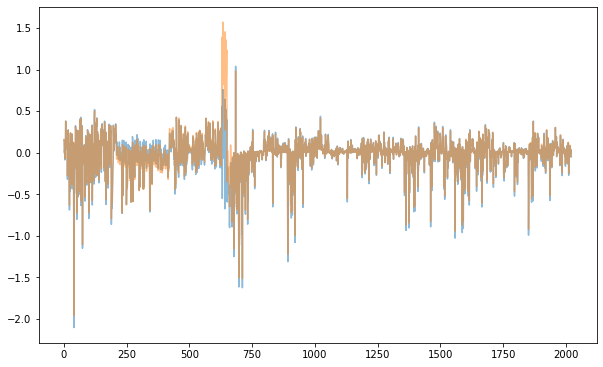

In [92]:
plt.plot(x, alpha=0.5)
plt.plot(gamma_mode16[722], alpha=0.5)

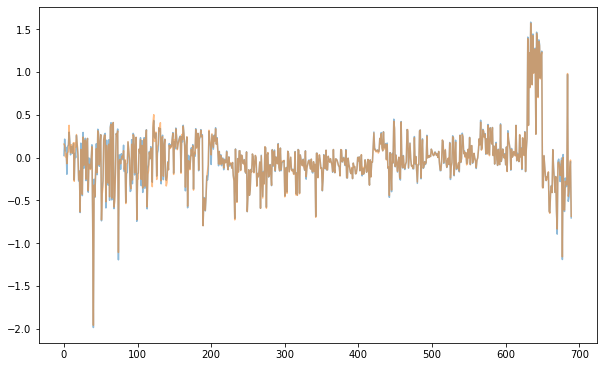

In [90]:
plt.plot(gamma_mode15[520][:690], alpha=0.5)
plt.plot(gamma_mode16[722][:690], alpha=0.5)

In [269]:
data = pd.read_csv("/Users/weilu/Research/server/oct_2020/curated_single_chain_optimization/optimization_msa_submode_15/z_scores.csv")

In [271]:
data.sort_values("Z")

,Unnamed: 0,Protein,E_native,E_decoy,E_diff,E_std,Z
73,73,2qfi_A,-28.017533,-2.461019e+01,3.407342,3.637535,0.936717
290,290,2lck_A,-5.009790,-8.322852e-09,5.009790,4.431393,1.130523
714,714,2gfp_A,-102.543241,-9.575537e+01,6.787866,5.991653,1.132887
451,451,6vja_D,-26.735181,-2.346513e+01,3.270056,2.781441,1.175670
583,583,2mgy_A,-38.204362,-3.444577e+01,3.758590,2.986710,1.258438
...,...,...,...,...,...,...,...
266,266,3rce_A,-145.930551,-1.015969e+02,44.333637,5.645482,7.852940
191,191,6kzo_A,-224.012710,-1.599975e+02,64.015227,8.140501,7.863794
167,167,5xti_j,-194.259449,-1.380684e+02,56.191035,6.829266,8.227976
51,51,6kzp_A,-240.179971,-1.709118e+02,69.268162,8.151418,8.497682


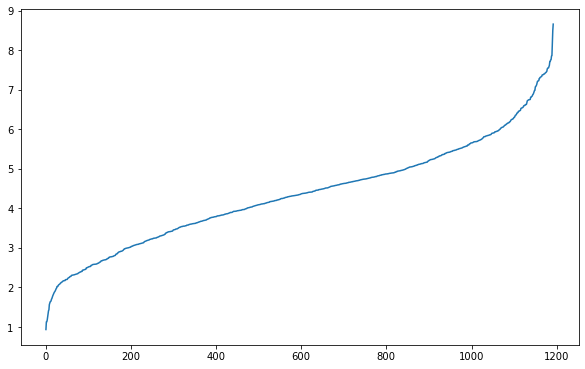

In [274]:
plt.plot(data.sort_values("Z").reset_index()["Z"])

## mode 15 repeats mode 9 (contact term only), but with bug-fixed

In [13]:
pre = "/Users/weilu/Research/server/oct_2020/curated_single_chain_optimization/optimization_msa_submode_15/gamma/"
mode_15 = get_A_B(pre, n=690)

In [14]:
A_B = mode_15
cutoff_range=list(range(400, 700, 20)) 
gamma_mode15 = get_gamma(A_B['A'], A_B['B'], A_B['A_prime'], c=-0, cutoff_range=cutoff_range)

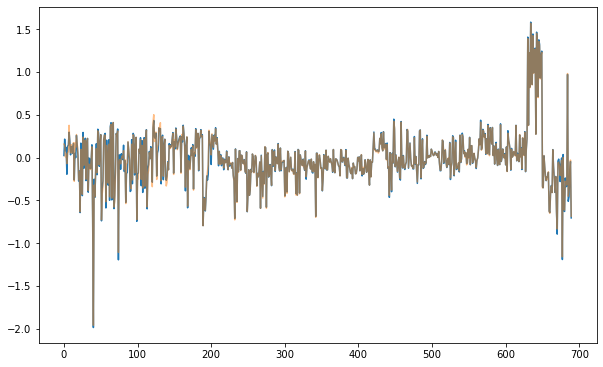

In [28]:
plt.plot(gamma_mode15[520][:690])
plt.plot(gamma_mode16[722][:690], alpha=0.5)
# plt.plot(gamma_mode15[520][:690])

In [22]:
# z score
B = A_B["B"]
A = A_B["A"]
A_prime = A_B["A_prime"]
# x = gamma_mode16[722]
x = gamma_mode15[520]
e_std = (np.dot(x, B).dot(x))**0.5
z = A.dot(x) / e_std
print(z, e_std, A.dot(x), A_prime.dot(x))

4.640464057648172 4.608435332275099 21.38527852141851 5.906386491005833e-14


In [23]:
# z score
B = A_B["B"]
A = A_B["A"]
A_prime = A_B["A_prime"]
x = gamma_mode16[722][:690]
# x = gamma_mode15[520]
e_std = (np.dot(x, B).dot(x))**0.5
z = A.dot(x) / e_std
print(z, e_std, A.dot(x), A_prime.dot(x))

4.5289848296963395 4.406746924004438 19.95808996712711 1.049871138799504


In [30]:
B = mode_15['B']
cutoff = 520
lamb, P = np.linalg.eig(B)
lamb, P = sort_eigenvalues_and_eigenvectors(lamb, P)
filtered_lamb = np.copy(lamb)
cutoff_mode = cutoff
filtered_B_inv, filtered_lamb, P = get_filtered_B_inv_lambda_and_P(filtered_lamb,
                                                                   cutoff_mode, P)
B_new = np.linalg.inv(filtered_B_inv)

In [75]:
from cvxopt import matrix, solvers
A_B = mode_15
# B = A_B['B']
B = B_new
A = A_B['A']
A_prime = A_B['A_prime']
n = len(A_prime)

Q = 2*matrix(B)
p = matrix(np.zeros(n))
# G = matrix(-A, (1,n))
# h = matrix(-7.117566, (1, 1), 'd')
additional_constraint = np.diag([-1]*n)
additional_constraint = A_B_6nq0_A['A_prime'].reshape(1,n)
additional_constraint = a_prime_all
# G = matrix(np.concatenate([-A.reshape(1,n), A_prime.reshape(1,n), additional_constraint]), (2+n,n))
# h = matrix([-21, -0]+[15]*n, (2+n, 1), 'd')
# G = matrix(np.concatenate([-A.reshape(1,n), A_prime.reshape(1,n), additional_constraint]), (2+1,n))
# h = matrix([-21, -0]+[-0], (2+1, 1), 'd')
n_additional_constraint = additional_constraint.shape[0]
G = matrix(np.concatenate([-A.reshape(1,n), A_prime.reshape(1,n), additional_constraint]), (2+n_additional_constraint,n))
h = matrix([-21, -0]+[-0]*n_additional_constraint, (2+n_additional_constraint, 1), 'd')
sol=solvers.qp(Q, p, G=G, h=h)
x = np.array(sol['x']).flatten()

     pcost       dcost       gap    pres   dres
 0:  2.6911e+01  1.1442e+02  2e+04  1e+01  2e+05
 1:  5.8358e+01 -2.1890e+03  3e+03  2e+00  2e+04
 2:  3.4914e+01 -3.8051e+02  4e+02  2e-01  3e+03
 3:  2.7041e+01 -5.1661e+01  8e+01  4e-02  6e+02
 4:  2.5327e+01  5.3632e+00  2e+01  1e-02  1e+02
 5:  2.4482e+01  1.8007e+01  6e+00  3e-03  4e+01
 6:  2.4024e+01  2.0099e+01  4e+00  2e-03  2e+01
 7:  2.3816e+01  2.0166e+01  4e+00  1e-03  2e+01
 8:  2.3373e+01  2.1974e+01  1e+00  5e-04  7e+00
 9:  2.3148e+01  2.1622e+01  2e+00  4e-04  5e+00
10:  2.2864e+01  2.1785e+01  1e+00  2e-04  3e+00
11:  2.2550e+01  2.2311e+01  2e-01  5e-05  7e-01
12:  2.2519e+01  2.2515e+01  4e-03  4e-07  6e-03
13:  2.2519e+01  2.2519e+01  4e-05  4e-09  6e-05
14:  2.2519e+01  2.2519e+01  4e-07  4e-11  6e-07
15:  2.2519e+01  2.2519e+01  4e-09  5e-13  6e-09
Optimal solution found.


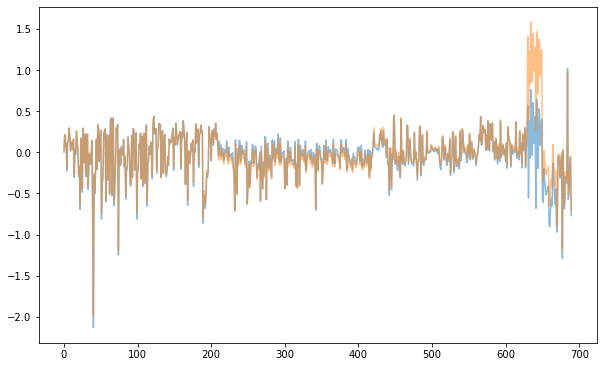

In [76]:
plt.plot(x, alpha=0.5)
plt.plot(gamma_mode15[520][:690], alpha=0.5)

In [73]:
# import glob
# ab_list = glob.glob("/Users/weilu/Research/server/oct_2020/curated_single_chain_optimization/optimization_msa_submode_15/A_B_dic/*.npy")
# a_prime_all = np.zeros((len(ab_list), 690))
# for abFile in ab_list:
#     A_B_one = np.load(abFile, allow_pickle=True).item()
#     a_prime_all = A_B_one["A_prime"]

abFile = "/Users/weilu/Research/server/oct_2020/curated_single_chain_optimization/optimization_msa_submode_15/a_prime_all.npy"
a_prime_all = np.load(abFile, allow_pickle=True)

In [74]:
a_prime_all

array([[1.87679006, 1.1369308 , 1.0812917 , ..., 1.23074547, 2.02222888,
        4.99261131],
       [4.85276668, 1.58350866, 1.40217948, ..., 1.84914302, 2.70250495,
        8.75344392],
       [0.9882021 , 0.60782271, 0.40400915, ..., 1.40091433, 1.79943992,
        3.7836284 ],
       ...,
       [0.39029175, 0.2278609 , 0.14997577, ..., 0.15530463, 0.06551744,
        0.62402178],
       [1.38424566, 1.25354991, 1.09497621, ..., 0.87404378, 1.34934104,
        2.70164878],
       [1.47953867, 0.79072309, 0.3829428 , ..., 1.34111058, 1.94186277,
        3.80409148]])

In [77]:
# z score
B = A_B["B"]
A = A_B["A"]
A_prime = A_B["A_prime"]
# x = gamma_mode16[722][:690]
# x = gamma_mode15[520]
e_std = (np.dot(x, B).dot(x))**0.5
z = A.dot(x) / e_std
print(z, e_std, A.dot(x), A_prime.dot(x))

4.44948869404758 4.719643411633881 21.000000000001105 -66.08984543497455


In [78]:
np.savetxt("/Users/weilu/Research/server/oct_2020/membrane_protein_structure_prediction/gamma_folder/new_mode15_all_prime.dat", x)

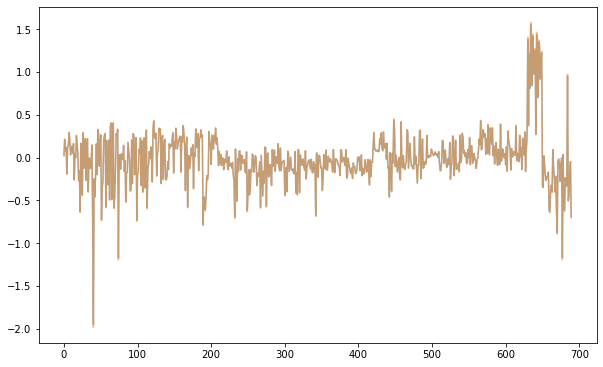

In [44]:
plt.plot(x, alpha=0.5)
plt.plot(gamma_mode15[520][:690], alpha=0.5)

In [4]:
pre = "/Users/weilu/Research/server/oct_2020/curated_single_chain_optimization/optimization_msa_submode_16/gamma/"
mode_16 = get_A_B(pre, n=2022)

In [5]:
A_B = mode_16
cutoff_range=list(range(522, 2122, 100)) 
gamma_mode16 = get_gamma(A_B['A'], A_B['B'], A_B['A_prime'], c=-0, cutoff_range=cutoff_range)

In [8]:
# z score
B = A_B["B"]
A = A_B["A"]
A_prime = A_B["A_prime"]
x = gamma_mode16[722]
e_std = (np.dot(x, B).dot(x))**0.5
z = A.dot(x) / e_std
print(z, e_std, A.dot(x), A_prime.dot(x))

5.006197747326388 4.816455992909468 24.11213114180006 2.372545519421787e-13


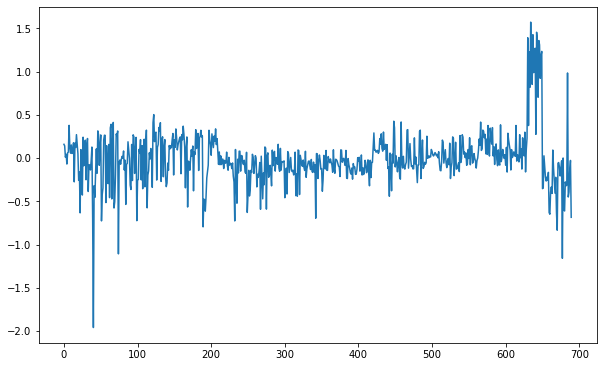

In [6]:
plt.plot(gamma_mode16[722][:690])

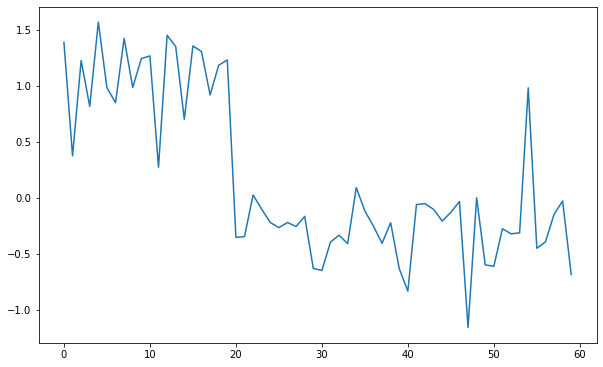

In [9]:
plt.plot(gamma_mode16[722][630:690])

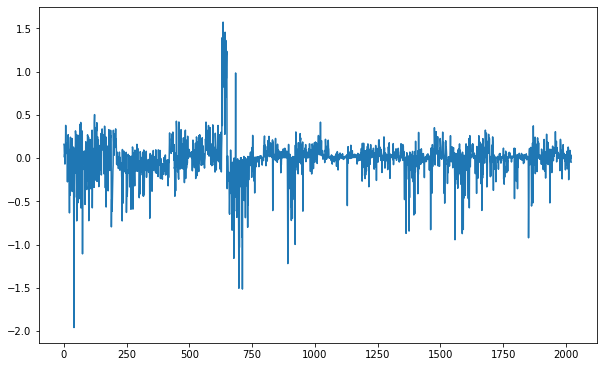

In [7]:
plt.plot(gamma_mode16[722])

In [10]:
toLocation = "/Users/weilu/Research/server/oct_2020/membrane_protein_structure_prediction/gamma_folder"
np.savetxt(f"{toLocation}/complete_cutoff722_contact_part_oct11.dat", x[:690])
np.savetxt(f"{toLocation}/complete_cutoff722_fourBody_part_oct11.dat", -x[690:])
np.savetxt(f"{toLocation}/complete_cutoff722_all_part_oct11.dat", x)

In [12]:
A_B["A_prime"].dot(gamma_mode16[722])

2.372545519421787e-13

In [ ]:
A_B = mode_16
B = A_B['B']
lamb, P = np.linalg.eig(B)
lamb, P = sort_eigenvalues_and_eigenvectors(lamb, P)
plt.plot(lamb)
plt.yscale("log")

In [24]:
pre = "/Users/weilu/Research/server/sep_2020//curated_single_chain_optimization/optimization_msa_submode_12/gamma/"
six_letter_submode12 = get_A_B(pre, n=690)
cutoff_range=list(range(190, 700, 10)) 
A_B = six_letter_submode12
gamma_six_letter_submode12 = get_gamma(A_B['A'], A_B['B'], A_B['A_prime'], c=-0, cutoff_range=cutoff_range)

In [35]:
np.savetxt("/Users/weilu/Research/server/sep_2020/membrane_protein_structure_prediction/gamma_folder/contact_submode12_cutoff550.dat", gamma_six_letter_submode12[550])

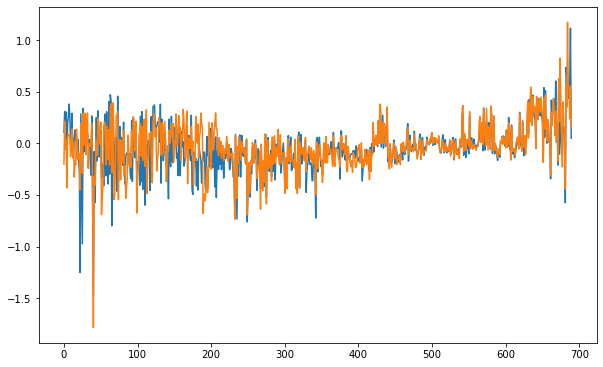

In [29]:
plt.plot(gamma_six_letter_submode12[450])
plt.plot(gamma_six_letter_submode9[450])

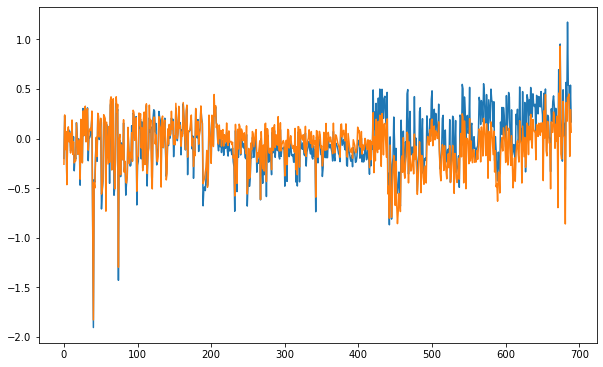

In [34]:

plt.plot(gamma_six_letter_submode9[550])
plt.plot(gamma_six_letter_mode9[550])

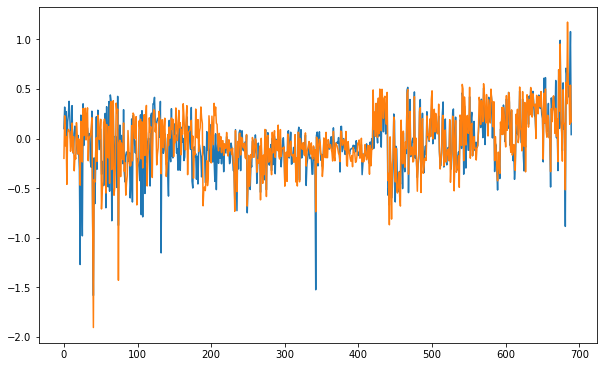

In [30]:
plt.plot(gamma_six_letter_submode12[550])
plt.plot(gamma_six_letter_submode9[550])